In [1]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal
import csv
import datetime
import pandas as pd

simworldname = 'simulationWorld2.xml' #ENVIROMENT
groundtruth = '28jun2.csv' #AGENT'S MOVEMENTS
motion_readings = '28Jun2_motion_events.txt'
# groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []
 
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# sensor_readings = open(motion_readings, "r")
sensor_readings = open(motion_readings, "r").readlines()

dataset_times = []
dataset_readings = []
for i in range(0,len(sensor_readings)):
    time = sensor_readings[i].split(';')[0]
    sensor_array = sensor_readings[i].split(';')[1]
    dataset_times.append(int(time))
    dataset_readings.append(sensor_array)

dataset = ['time', 'gt(x)', 'gt(y)', 'motion_readings']
with open(groundtruth, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        new_row = []
        if (reader.line_num != 1):
            ind = find_nearest(dataset_times[1:], int(row[0]))
            dataset = np.vstack((dataset, [float(row[0]), float(row[4]), float(row[5]), dataset_readings[ind]]))
            

In [3]:
dataset

array([['time', 'gt(x)', 'gt(y)', 'motion_readings'],
       ['1498670641.0', '1.197742', '5.402001', '0000000000000000000000'],
       ['1498670642.0', '1.198065', '5.401716', '0000000000000000000000'],
       ...,
       ['1498677300.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677303.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677318.0', '3.4', '3.45', '0000000000000000010000']],
      dtype='<U32')

In [4]:
motions_order = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
motions_sensor_data = {}

sr_matrix = np.zeros([1, 14])
for i in range(1,len(dataset)):
    sensor_array = dataset[i][3]
    sr_row = []
    for j in range(0,len(sensor_array)):
        if (motions_order[j] <= 14):
            sr_row.append(int(sensor_array[j]))

    sr_matrix = np.vstack((sr_matrix,sr_row))

i = 0
for sensor in motions_order:
    if (sensor <= 14):
        motions_sensor_data[sensor] = []
        motions_sensor_data[sensor] = sr_matrix[:, i]
        i = i + 1
        
for sensor in motion_sensors:
    new_readings = []
    new_readings.append(motions_sensor_data[sensor][0])
    for i in range(1, len(motions_sensor_data[sensor])):
        if (new_readings[len(new_readings) - 1] == motions_sensor_data[sensor][i]):
            new_readings.append(0)
        else:
            new_readings.append(1)

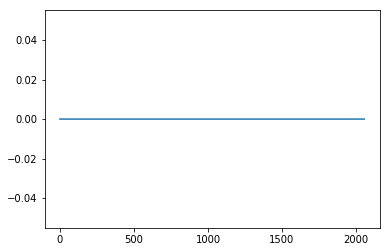

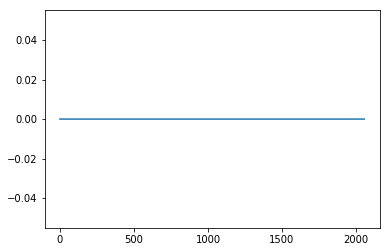

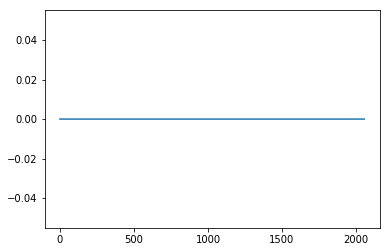

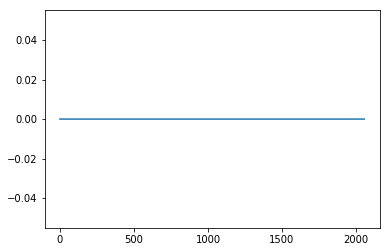

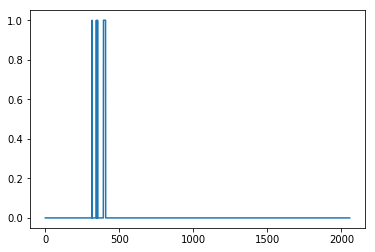

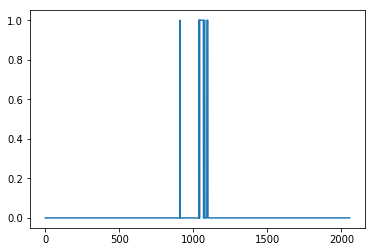

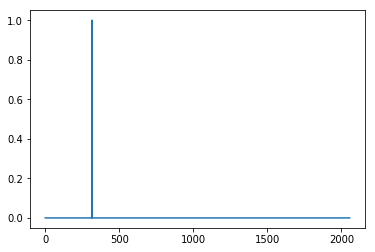

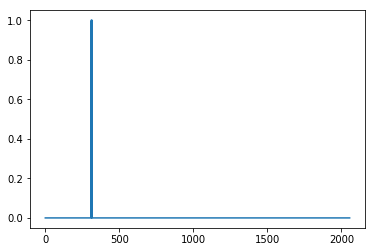

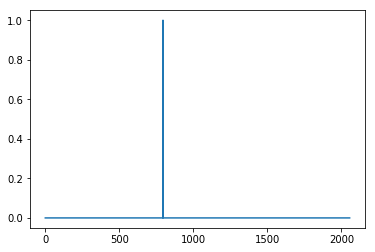

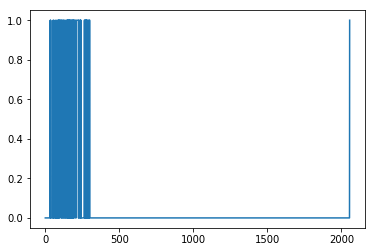

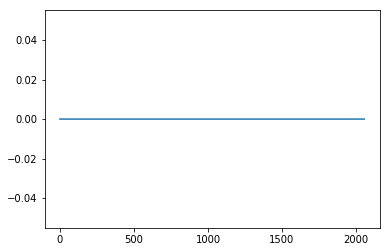

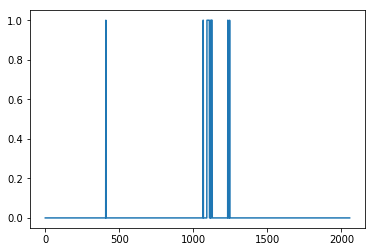

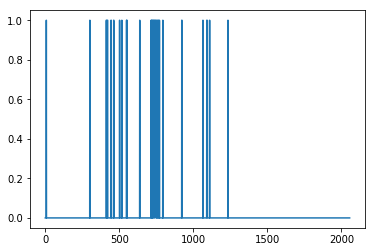

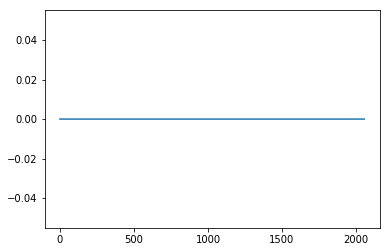

In [5]:
import matplotlib.pyplot as plt

for i in motion_sensors:
    plt.plot(list(range(0,len(motions_sensor_data[i]))), motions_sensor_data[i])
    plt.show()

In [6]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    
    '''
        This fucntion uses an 2D gaussian, that means: X~(x, mean, covarianceMatrix)
        Input:
        x = [xOracle, yOracle] (Actually we don't care about it anymore)
        mean = [xSimulator, ySimulator]
        covarianceMatrix= | r  0 | , where r is the circle radious
                          | 0  r |

        Returns: cdf of the normal distribution
        
    '''
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        # print("real: ", real_localization)
        # print("simu: ", simulated_localization)
              
        return probCdf
    
"""
System's sensors
All this classes are childrens from Sensor Class
"""
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist
    
   # def distanceToMeasure(self, dist):
     #   mp = self.RSSI + (10*n*math.log10(dist)
    #    return mp
    

In [7]:
#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))

In [8]:
class GridMap:
    map = ""

In [9]:
#Debug function, not working - just forget about it
def checkTypeSensor(sensor):
    if(sensor.sensor_type == 'RFID_Reader'):
        this_sensor = RFID_Reader(sensor) 
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorBinary'):
        this_sensor = MotionSensorBinary(sensor)
        #this_sensor = sensor
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorAnalog'):
        this_sensor = MotionSensorAnalog(sensor)
        return this_sensor

    if(sensor.sensor_type == 'PressureSensorAnalog'):
        this_sensor = PressureSensorAnalog(sensor)
        return this_sensor
    
    return "none"

In [10]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

root = xml.etree.ElementTree.parse(simworldname).getroot()

grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
grid2 = np.copy(grid_map)

# print(grid2)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            #Choose the kind of sensor we have
            if(str(sensor.find('type').text) == 'RFID_Reader'):
                this_sensor = RFID_Reader(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                this_sensor = MotionSensorBinary(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                this_sensor = MotionSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                this_sensor = PressureSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'BeaconSensor'):
                this_sensor = BeaconSensor(sensor)
                
            sensors_list.append(this_sensor)
            print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y + " " + this_sensor.sensor_id)
            
            # print(sensors_list[len(sensors_list) - 1])

BeaconSensor 479 405 sensorBC1
PressureSensorAnalog 479 405 sensorPS1
MotionSensorBinary 455 405 sensor1
MotionSensorBinary 479 284 sensor2
MotionSensorBinary 509 101 sensor3
MotionSensorBinary 183 389 sensor4
MotionSensorBinary 271 225 sensor5
MotionSensorBinary 91 225 sensor6
MotionSensorBinary 466 894 sensor7
MotionSensorBinary 426 626 sensor8
MotionSensorBinary 122 861 sensor9
MotionSensorBinary 244 1003 sensor10
MotionSensorBinary 215 711 sensor11
MotionSensorBinary 183 577 sensor12
MotionSensorBinary 574 527 sensor13
MotionSensorBinary 574 688 sensor14


In [11]:
############################################
####         LOCALIZATION CLASS         ####
############################################
simulated_sensor_readings = []

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

          
        
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                                 
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):
                #finds the inferred an real locations, and what sensors were fired
#         inferred_location, real_location, fired_sensors = self.getLocations(event.timestamp, event)    
        
        # k = 0
        # i = len(fired_sensors2)
        
        # if(i > 0):
        #     i -= 1
        
        # while(i >= 0):         
        #     current_sensor = fired_sensors2[i]
            #get the probability from the gaussian filter
        #     probi = current_sensor.GaussianFiredSensor(inferred_location, real_location)
            
            # COMMENTED OUT FOR EXPERIMENTS
            # if(probi < 0.015):
                # del fired_sensors2[i]
        #     i -= 1
            #print(probi)
                
        # fired_sensors = fired_sensors2
        
        
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        

        
        self.SimulateSensorReading(fired_sensors) 
        
        counter = 0
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        #Bruno's code here
        
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    circ = Circle((int(float(sensor.x)/10), int(float(sensor.y)/10)), int(float(sensor.sensing_area)/10))
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
            
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)

        # plt.imshow(grid_map, cmap='hot', interpolation='nearest')
        # plt.show()
        
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist)
        
        # print(dist)
    
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        print("infered loc:")
        print(inferred_location)
        print("real loc:")
        print(real_location)
        
        xlim=(0, 200)
        ylim=(0, 200)
        
        
        p1 = plt.scatter(real_location[0], real_location[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(inferred_location[0], inferred_location[1], marker='s', color='r')
        
        plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        # print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
        plt.show()
        
        return np.linalg.norm(inferred_location - real_location)
        
    def SimulateSensorReading(self, fs):
        sensor_bins = [0] * 14
        
        for sensor in fs:
            if (sensor.sensor_type == 'MotionSensorBinary'):
                snum = int(sensor.sensor_id.replace('sensor',''))
                sensor_bins[motion_sensors.index(snum)] = 1
                
        simulated_sensor_readings.append(sensor_bins)
        print(len(simulated_sensor_readings))
    
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == int(time))], axis = 0)
        #print("ponto: ", point, "time: ", time)
        return point
    
    """
    I'm implementing a randomic action fiture for the sensors, causing false-positive events. Basically, 
    to choose WHICH sensor will be deployed, I get an random number between [0 - (X - 1)], where X is the length 
    of the sensor list. To choose WHEN the sensor is deployed, I'll define a variable called "control = 123", and
    create a list of random 10 numbers between [0 - 150], everytime the list contains whe variable control, we
    switch to the random event.
    """
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        # COMMENTED OUT FOR EXPERIMENTS
        # listControl = random.sample(range(0, 150), 10)
        # control = 123
        
        # if(control in listControl):  
        #     rand = randint(0, len(sensors_list) - 1)
        #     current_sensor = sensors_list[rand]
        #     fired_sensors2.append(current_sensor)
        
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [12]:
#temporary:
# my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
# grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
# print("first input")
# result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
# event = ParseResult(result)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()

# print('---------------------------')

# print(np.max(grid_map))
# print("second input")
# result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
# event = ParseResult(result1)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()



In [13]:
#Debug function, sees what kind of activity we have
def typeAction(type):
    if(type == "Sleep"):
        print(type + "ENTREI")

    if(type == "walk"):
        print(type + "ENTREI")
        
    if(type == "Water"):
        print(type + "ENTREI")
        
    if(type == "Wash"):
        print(type + "ENTREI")
        
    if(type == "Entertainment"):
        print(type + "ENTREI")
        
    if(type == "Exercise"):
        print(type + "ENTREI")

    if(type == "Clean"):
        print(type + "ENTREI")
        
    if(type == "Eat"):
        print(type + "ENTREI")
        
    if(type == "Sit"):
        print(type + "ENTREI")

In [14]:
"""
Function to read the path in the csv file and turn it on an event.
The event is composed of: (sensor Id, data, hash, source, time)
Everytime that a sensor finds
"""
def readFileCSV():             
    for i in range(1, len(dataset)):
        no_event_flag = 1
        xtrace = float(dataset[i][1])
        ytrace = float(dataset[i][2])
        x = abs(float(xtrace)) * 10
        y = abs(float(ytrace)) * 10
        loc = [x, y]
        timetoadd = int(round(float(dataset[i][0])))
        
        if loc not in oracle['location'] and timetoadd not in oracle['time']:

            oracle['location'].append(loc)
            oracle['time'].append(timetoadd) 
        
        for sensor in sensors_list:
            # print(sensor.sensor_type)
            # if(sensor.sensor_type == "BeaconSensor"):
                # no_event_flag = 0
                # event = Event()
                # event.RSSI = sensor.RSSI #RSSI, just for beacons
                # event.accelerometer = sensor.accelerometer #if it's moving or not - jsut for beacon
                # event.objectAtt = sensor.object #Object where the sensor is
                
                # event.RSSI = 0 #RSSI, just for beacons
                # event.objectAtt = "" #Object where the sensor is
                # event.accelerometer = False #if it's moving or not - jsut for beacon
                # continue
                
            # elif(sensor.sensor_type == "PressureSensorAnalog"):
                # continue
                # no_event_flag = 0
                # event.objectAtt = sensor.object #Object where the sensor is
            
            if (sensor.sensor_type == "MotionSensorBinary"):    
                circ = Circle((int(int(sensor.x) / 10), int(int(sensor.y) / 10)), int(int(sensor.sensing_area) / 10))
                if (circ.contains_point([x, y])):
                    no_event_flag = 0
                    event = Event()
                    event.sensor = sensor.sensor_id #SensorId that created the event
                    event.data = "TRUE"  #data
                    event.hash = "|hash|" #hash
                    event.source = "xmlFile" #where is coming from
                    event.timestamp = int(round(float(dataset[i][0]))) #timestamp
                    event.sensorType = sensor.sensor_type #type of sensor

                    run_localization(event)
                    
            # else:
                # sensor_bins = [0] * 14
                # simulated_sensor_readings.append(sensor_bins)    
            
        # if (no_event_flag == 1):
        #     sensor_bins = [0] * 14
        #     simulated_sensor_readings.append(sensor_bins)
        # no_event_flag = 0
        
        

        

1
start!
infered loc:
[45.         40.05357143]
real loc:
[41.8 42.6]


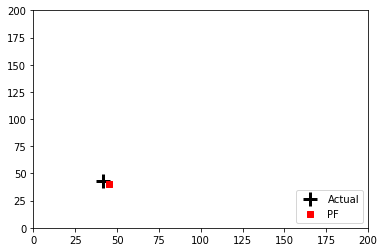

2
infered loc:
[55.69047619 68.07142857]
real loc:
[60. 65.]


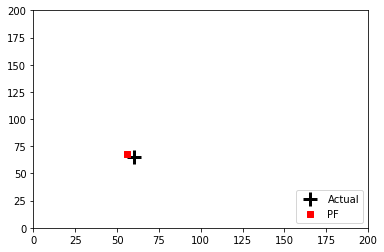

3
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


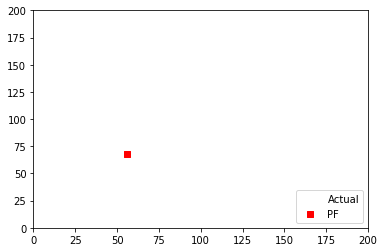

4
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


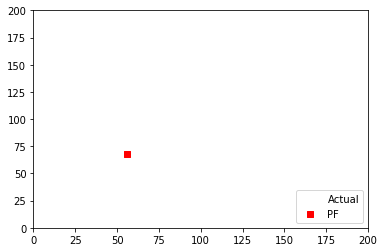

5
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


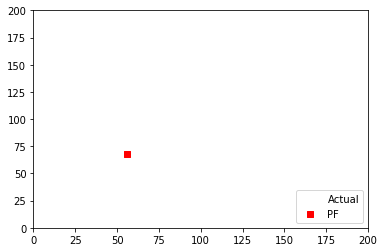

6
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


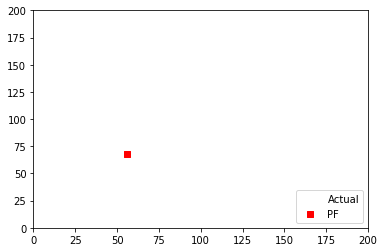

7
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


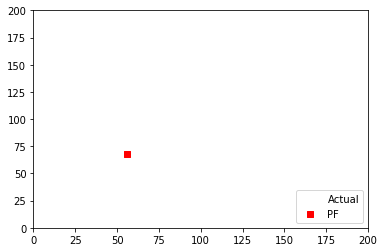

8
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


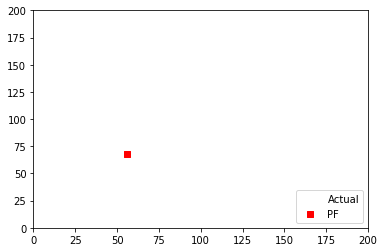

9
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


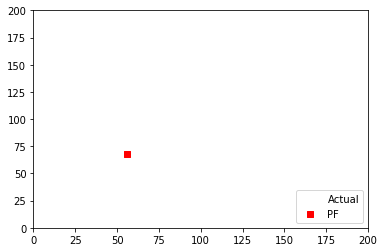

10
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


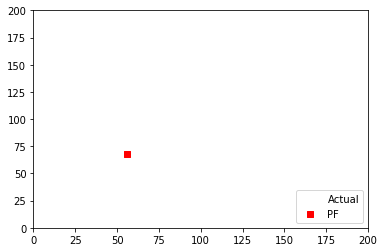

11
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


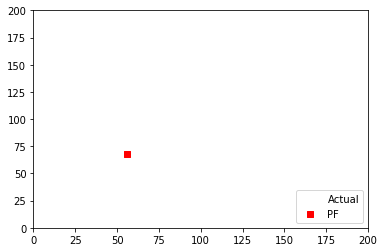

12
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


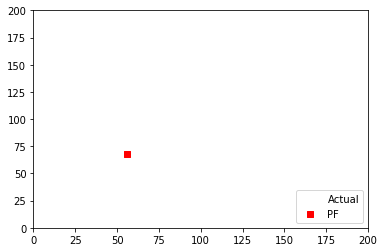

13
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


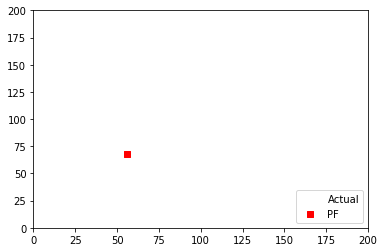

14
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


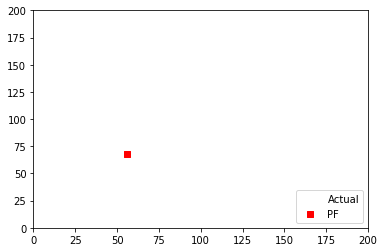

15
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


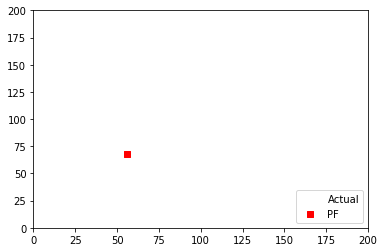

16
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


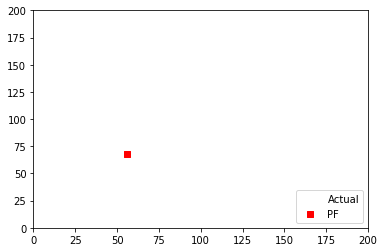

17
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


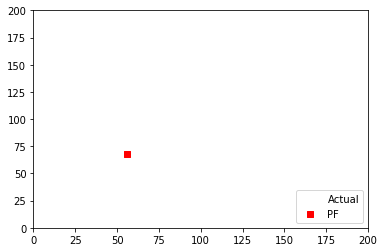

18
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


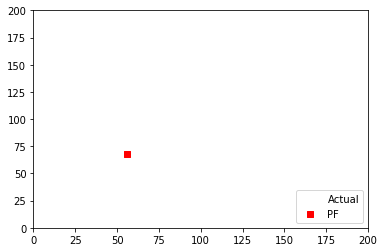

19
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


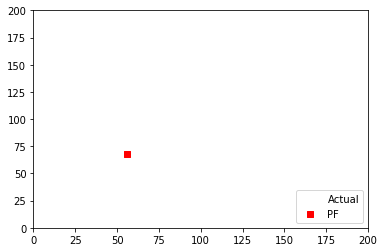

20
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


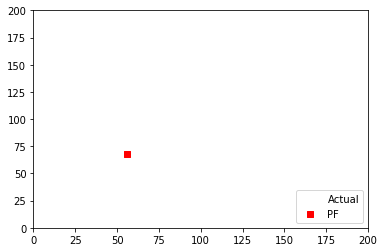

21
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


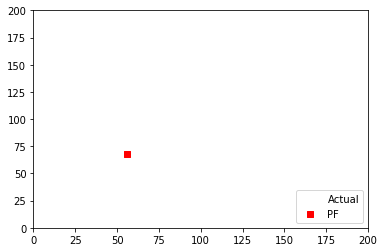

22
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


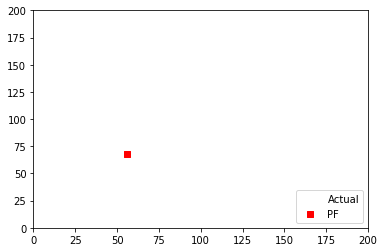

23
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


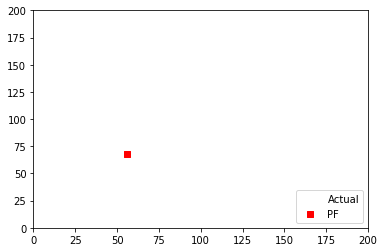

24
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


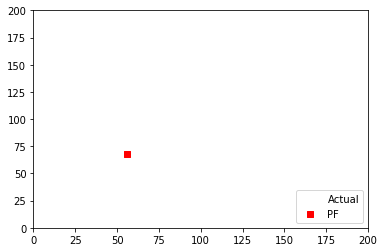

25
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


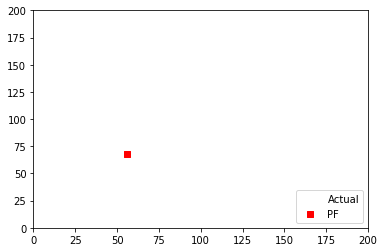

26
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


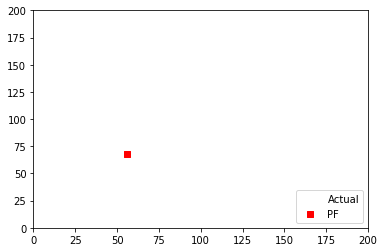

27
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


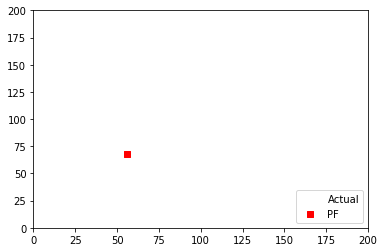

28
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


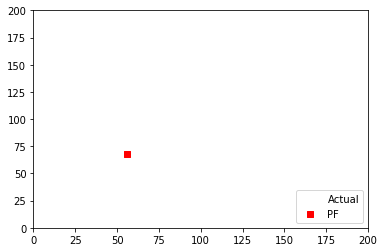

29
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


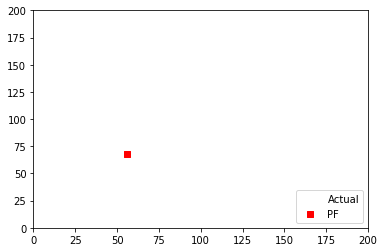

30
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


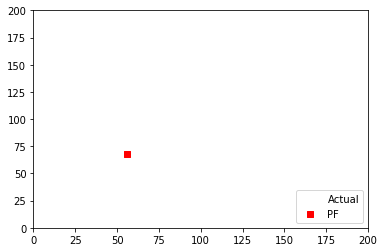

31
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


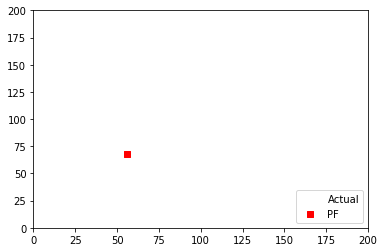

32
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


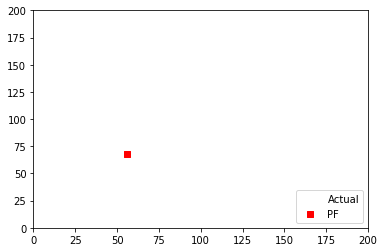

33
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


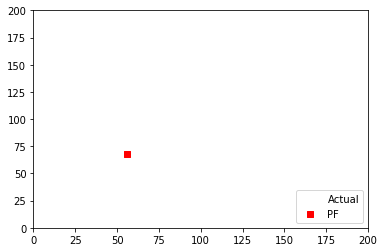

34
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


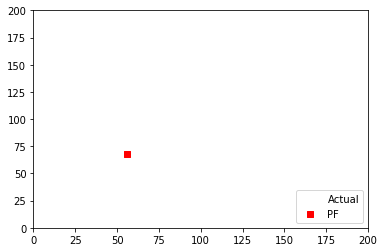

35
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


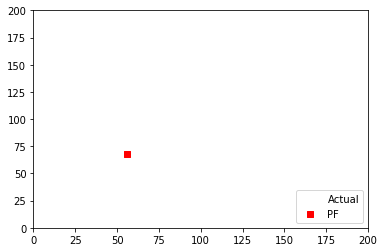

36
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


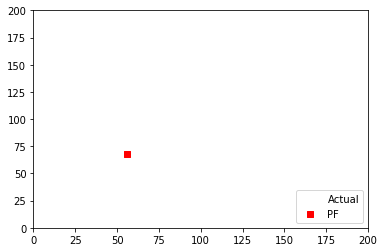

37
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


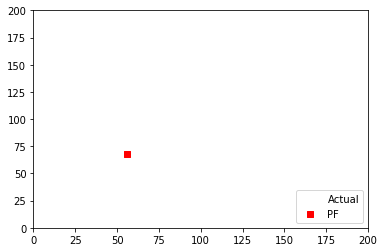

38
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


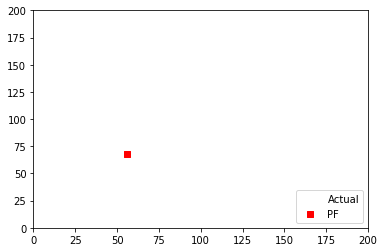

39
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


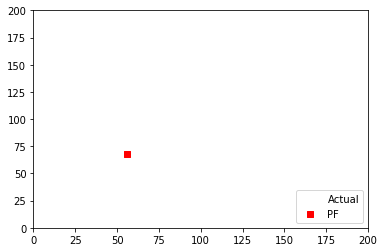

40
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


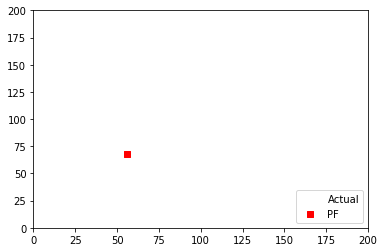

41
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


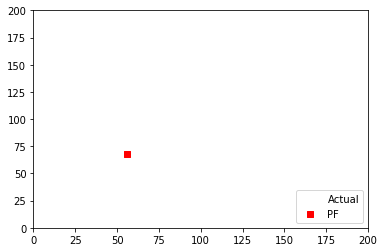

42
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


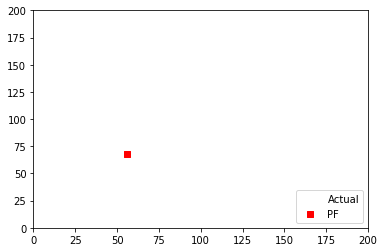

43
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


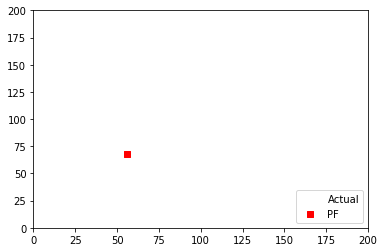

44
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


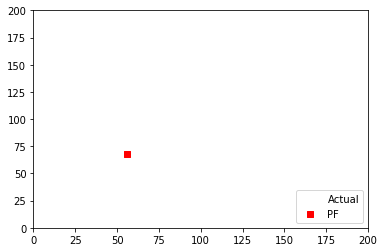

45
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


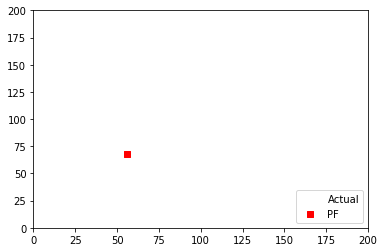

46
infered loc:
[55.69047619 68.07142857]
real loc:
[61.33333 68.     ]


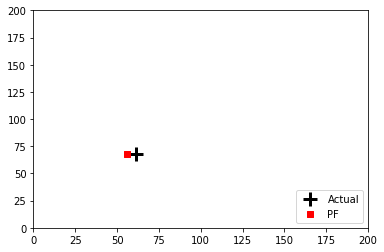

47
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


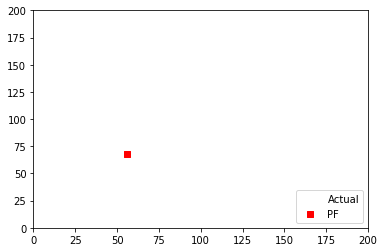

48
infered loc:
[55.69047619 52.07142857]
real loc:
[60. 49.]


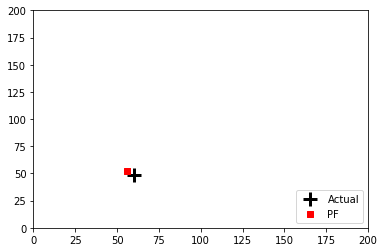

49
infered loc:
[42.         62.05357143]
real loc:
[45.      66.33333]


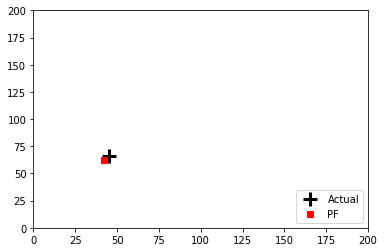

50
infered loc:
[42.         62.05357143]
real loc:
[44.86364 66.49091]


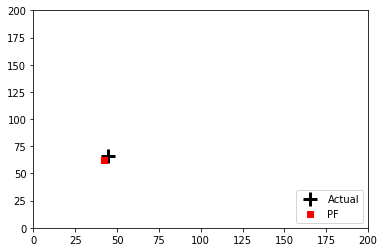

51
infered loc:
[42.         62.05357143]
real loc:
[45.27273 66.01818]


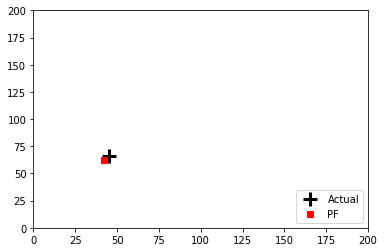

52
infered loc:
[42.         62.05357143]
real loc:
[45.68182 65.54545]


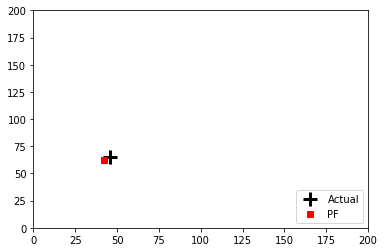

53
infered loc:
[42.         62.05357143]
real loc:
[46.09091 65.07273]


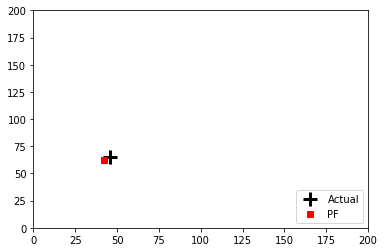

54
infered loc:
[42.         62.05357143]
real loc:
[46.5 64.6]


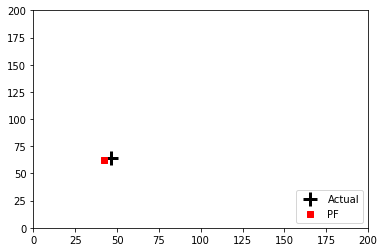

55
infered loc:
[42.         62.05357143]
real loc:
[46.90909 64.12727]


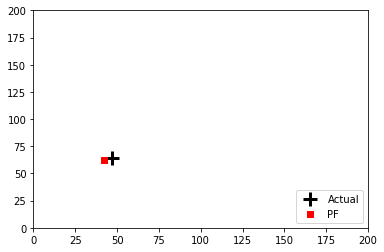

56
infered loc:
[42.         62.05357143]
real loc:
[47.31818 63.65455]


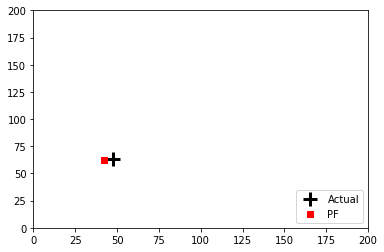

57
infered loc:
[55.69047619 52.07142857]
real loc:
[55.5 54.2]


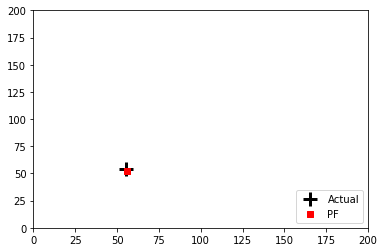

58
infered loc:
[55.69047619 52.07142857]
real loc:
[55.90909 53.72727]


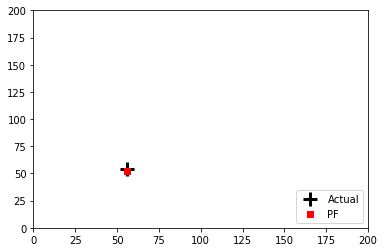

59
infered loc:
[55.69047619 52.07142857]
real loc:
[56.31818 53.25455]


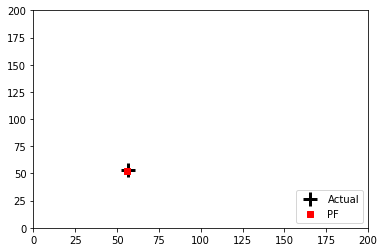

60
infered loc:
[55.69047619 52.07142857]
real loc:
[56.72727 52.78182]


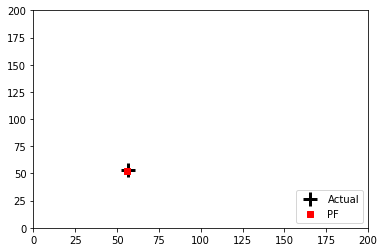

61
infered loc:
[55.69047619 52.07142857]
real loc:
[57.13636 52.30909]


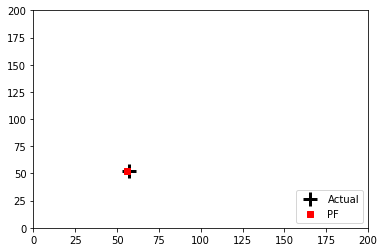

62
infered loc:
[55.69047619 52.07142857]
real loc:
[57.54545 51.83636]


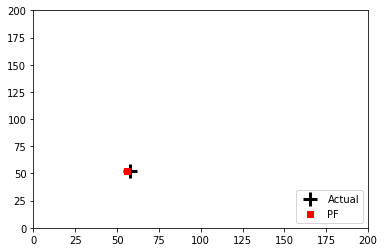

63
infered loc:
[55.69047619 52.07142857]
real loc:
[57.95455 51.36364]


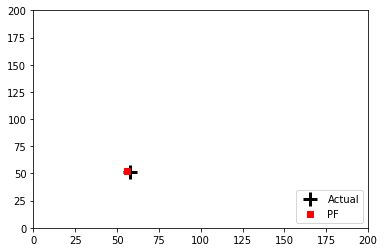

64
infered loc:
[55.69047619 52.07142857]
real loc:
[58.36364 50.89091]


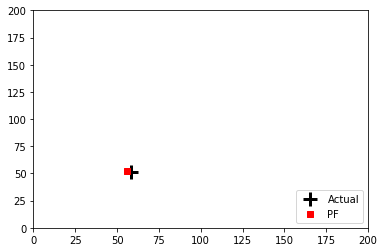

65
infered loc:
[55.69047619 52.07142857]
real loc:
[58.77273 50.41818]


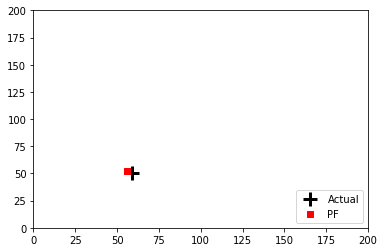

66
infered loc:
[55.69047619 52.07142857]
real loc:
[59.18182 49.94545]


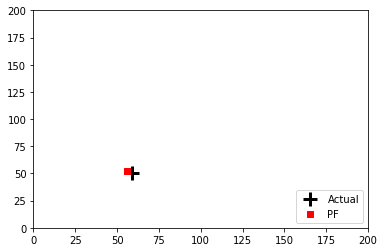

67
infered loc:
[24.         97.20408163]
real loc:
[ 25. 102.]


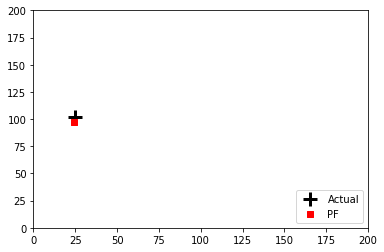

68
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


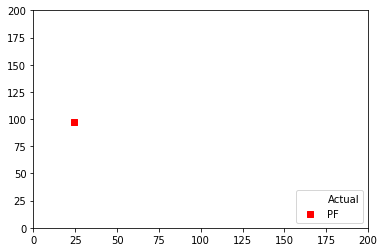

69
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


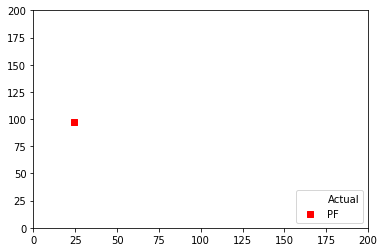

70
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


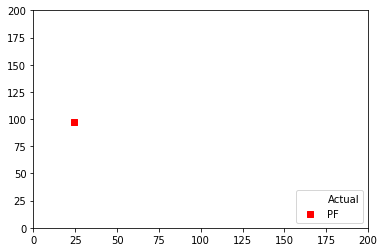

71
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


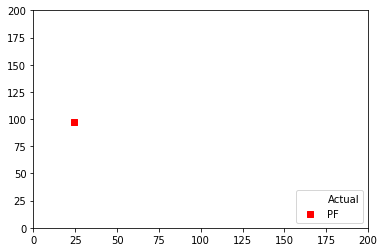

72
infered loc:
[24.         97.20408163]
real loc:
[ 18.5 102. ]


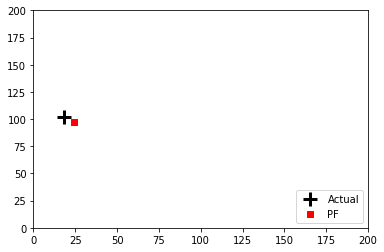

73
infered loc:
[24.         97.20408163]
real loc:
[ 21.75 102.  ]


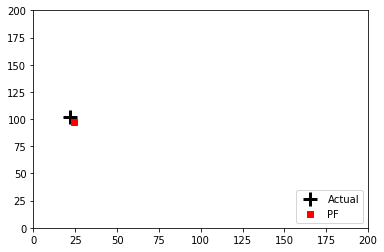

74
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


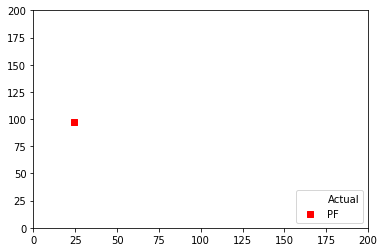

75
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


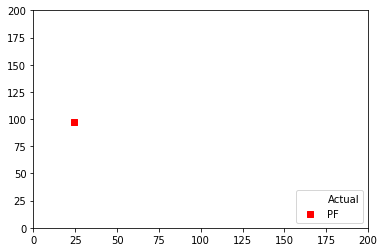

76
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


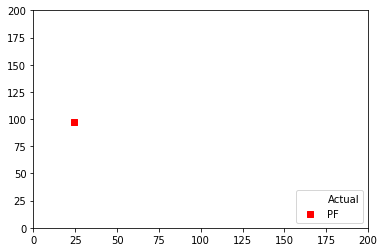

77
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


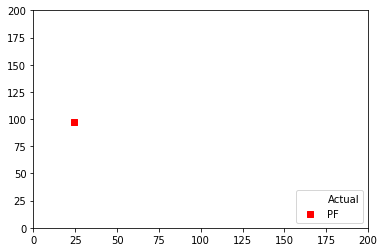

78
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


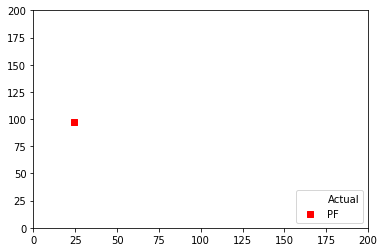

79
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


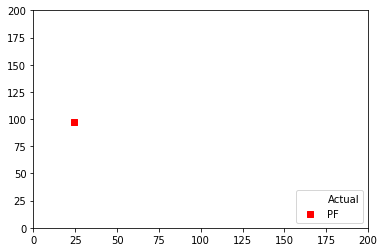

80
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


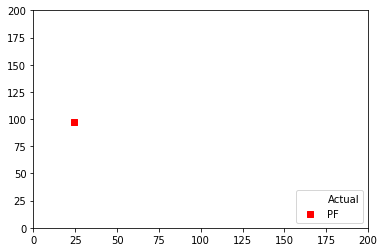

81
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


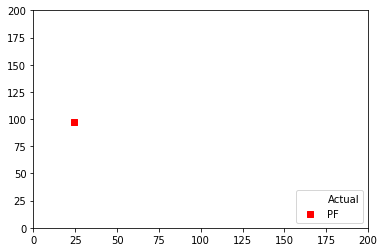

82
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


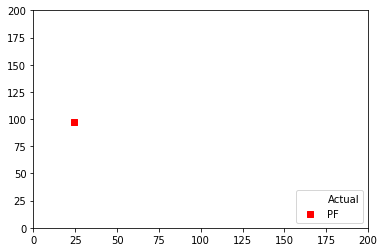

83
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


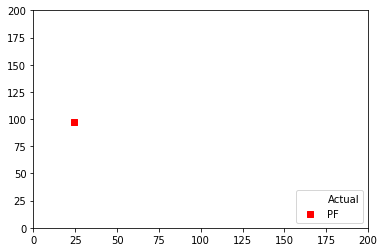

84
infered loc:
[24.         97.20408163]
real loc:
[20.7 95.8]


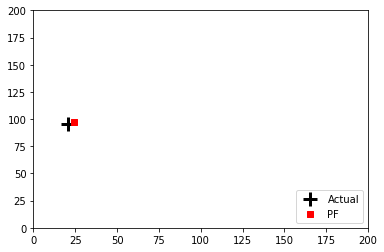

85
infered loc:
[21.         71.05357143]
real loc:
[21.33333 69.33333]


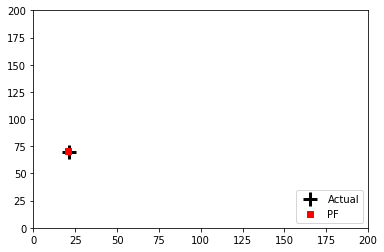

86
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


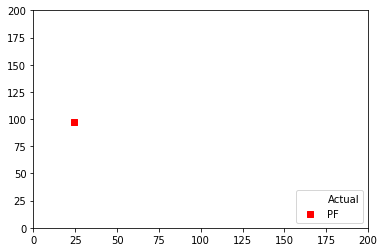

87
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


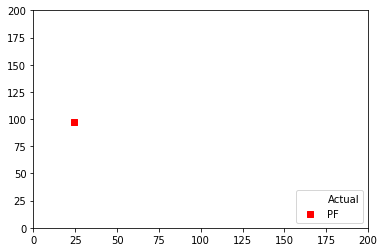

88
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


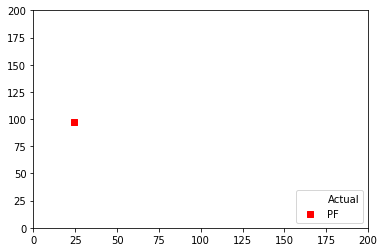

89
infered loc:
[24.         97.20408163]
real loc:
[25.9 95.8]


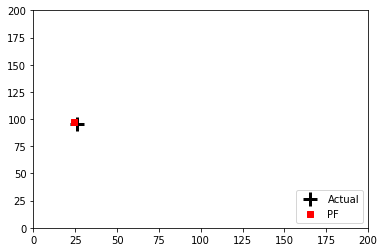

90
infered loc:
[21.         71.05357143]
real loc:
[17.25 68.5 ]


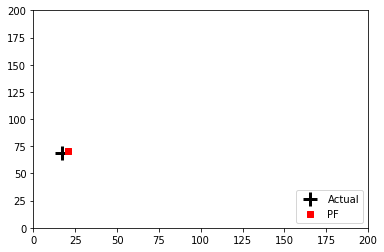

91
infered loc:
[21.         71.05357143]
real loc:
[16.08333 68.2619 ]


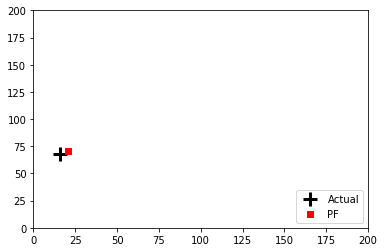

92
infered loc:
[21.         71.05357143]
real loc:
[17.83333 68.61905]


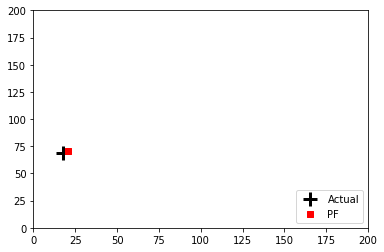

93
infered loc:
[21.         71.05357143]
real loc:
[26.58333 70.40476]


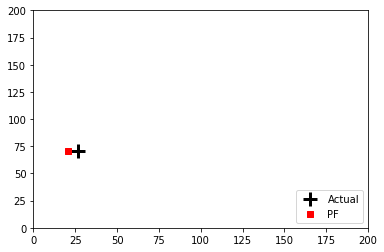

94
infered loc:
[21.         71.05357143]
real loc:
[nan nan]


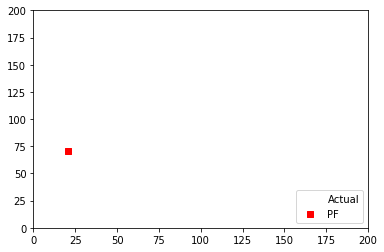

95
infered loc:
[21.         71.05357143]
real loc:
[19.7 69. ]


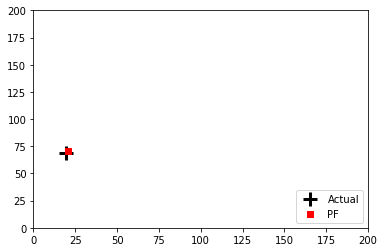

96
infered loc:
[24.         97.20408163]
real loc:
[ 18.98148 102.     ]


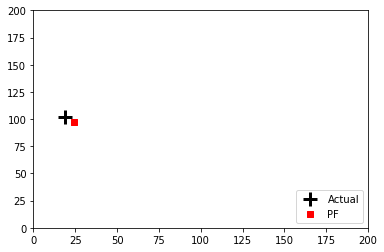

97
infered loc:
[24.         97.20408163]
real loc:
[ 20.42593 102.     ]


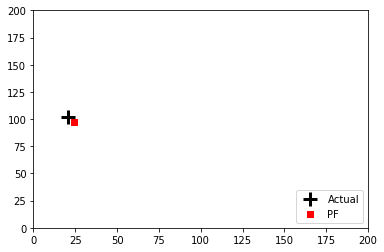

98
infered loc:
[24.         97.20408163]
real loc:
[ 21.14815 102.     ]


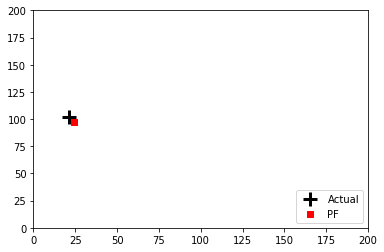

99
infered loc:
[24.         97.20408163]
real loc:
[ 21.87037 102.     ]


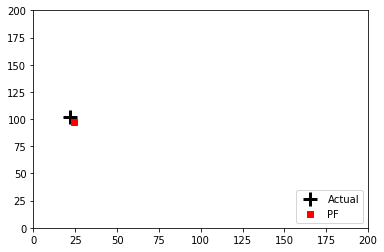

100
infered loc:
[24.         97.20408163]
real loc:
[ 22.59259 102.     ]


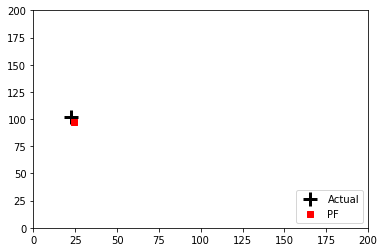

101
infered loc:
[24.         97.20408163]
real loc:
[ 23.31481 102.     ]


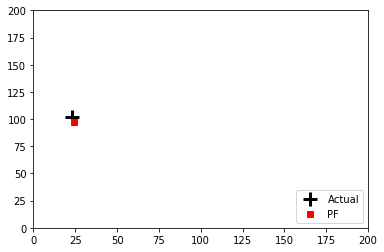

102
infered loc:
[24.         97.20408163]
real loc:
[ 24.03704 102.     ]


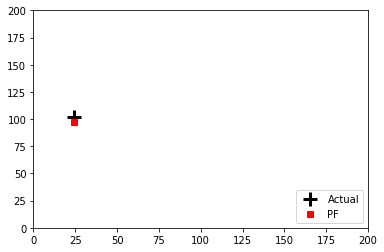

103
infered loc:
[18.         57.05357143]
real loc:
[23. 54.]


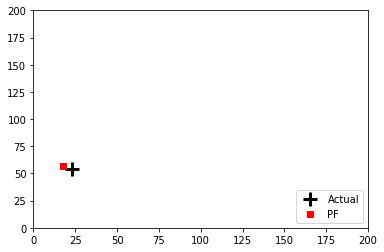

104
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


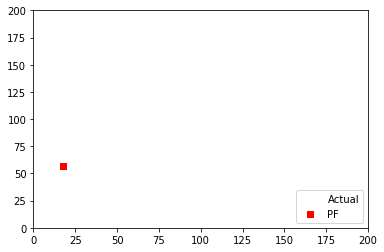

105
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


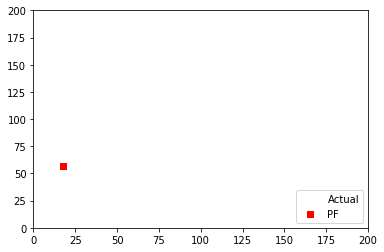

106
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


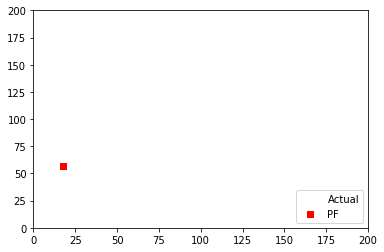

107
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


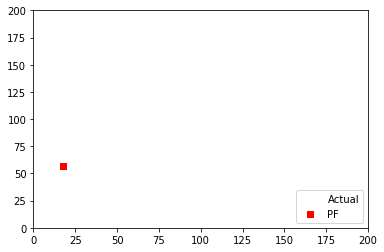

108
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


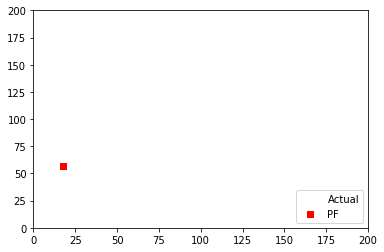

109
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


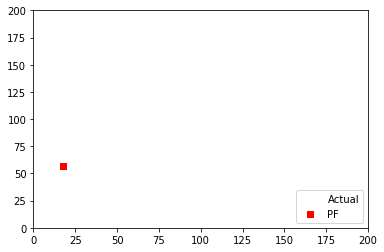

110
infered loc:
[18.         57.05357143]
real loc:
[17. 58.]


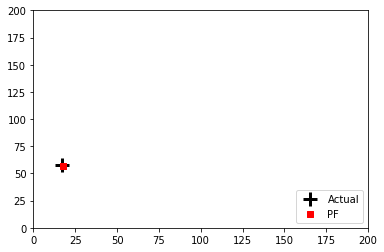

111
infered loc:
[18.         57.05357143]
real loc:
[18.5 57. ]


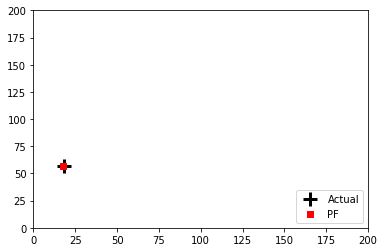

112
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


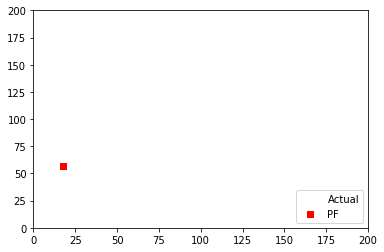

113
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


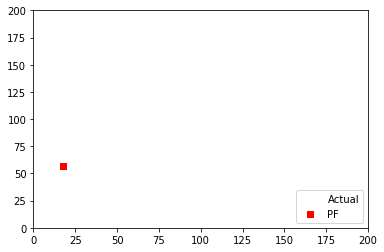

114
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


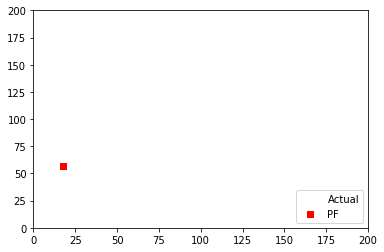

115
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


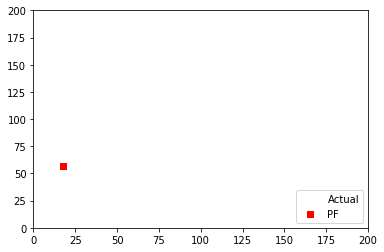

116
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


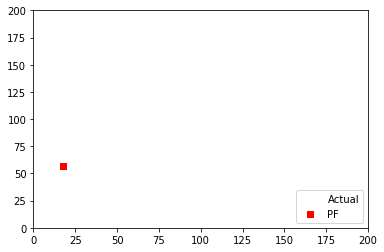

117
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


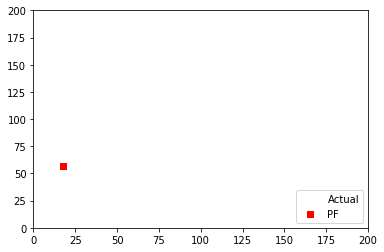

118
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


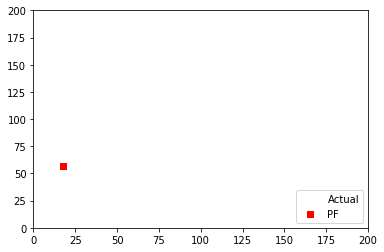

119
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


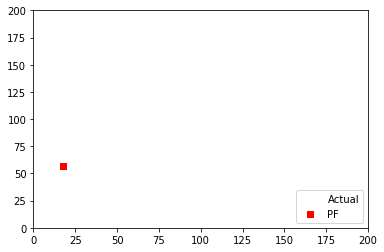

120
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


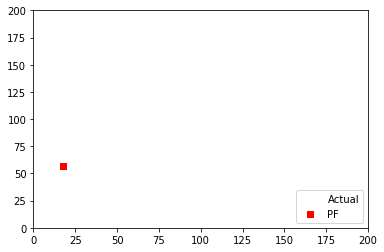

121
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


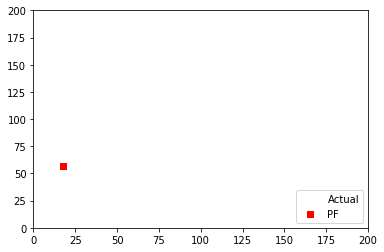

122
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


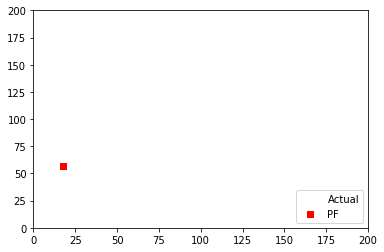

123
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


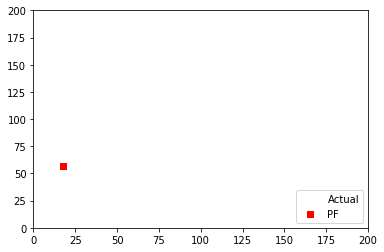

124
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


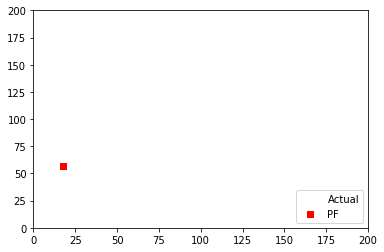

125
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


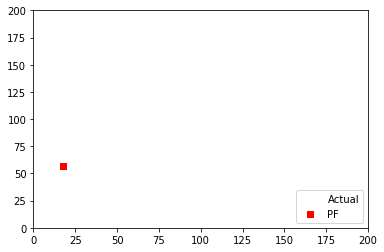

126
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


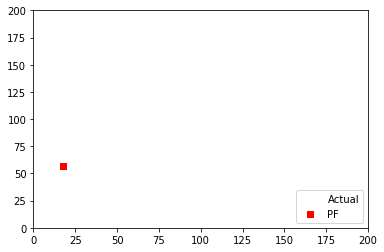

127
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


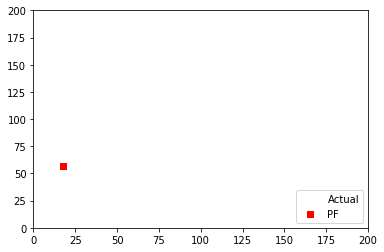

128
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


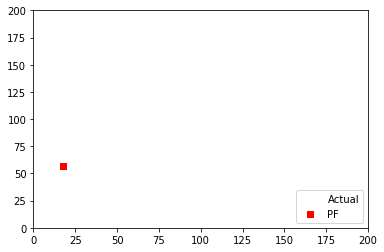

129
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


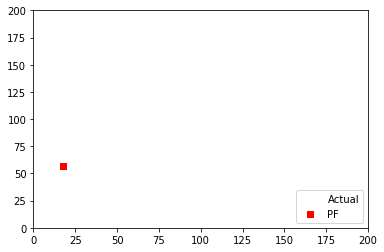

130
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


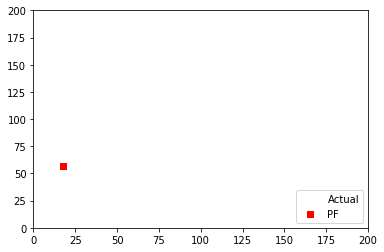

131
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


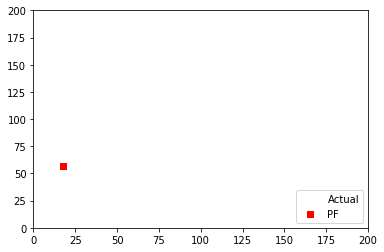

132
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


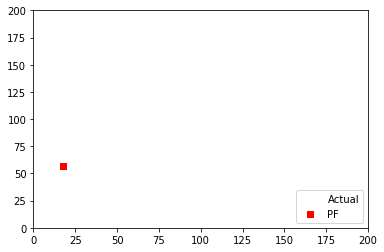

133
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


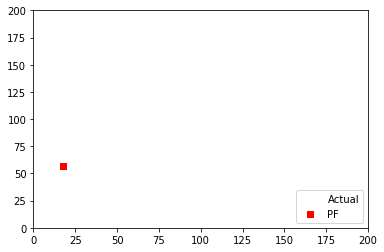

134
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


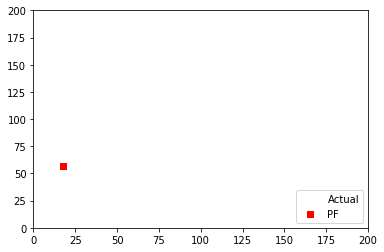

135
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


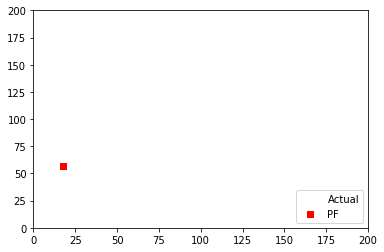

136
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


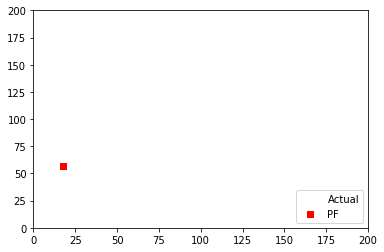

137
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


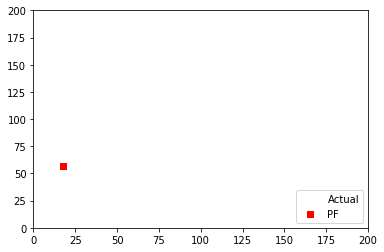

138
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


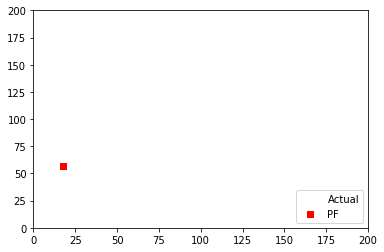

139
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


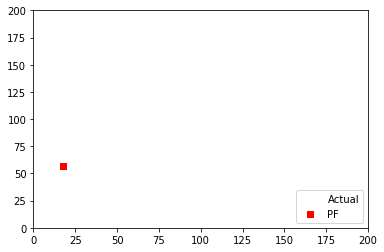

140
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


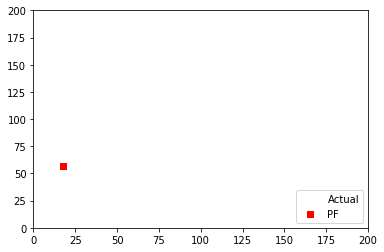

141
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


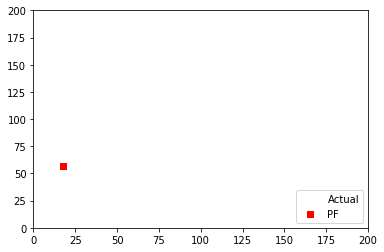

142
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


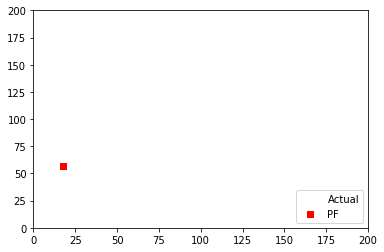

143
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


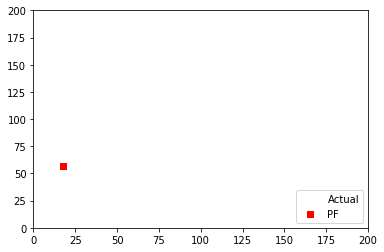

144
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


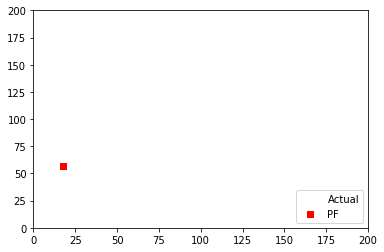

145
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


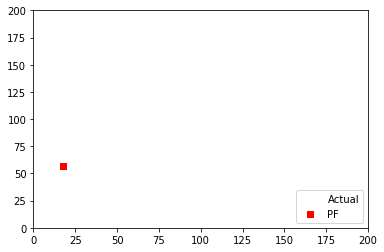

146
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


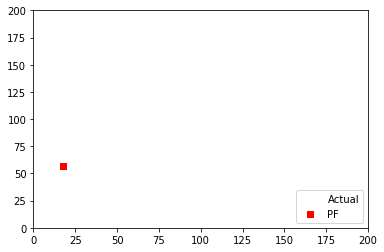

147
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


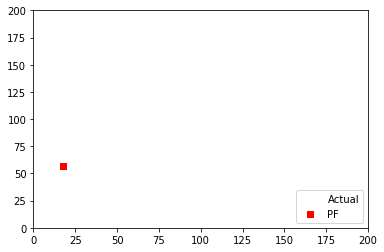

148
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


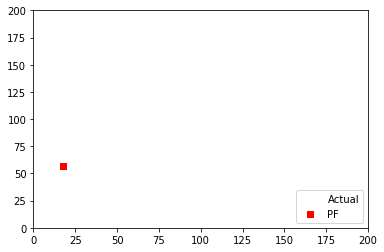

149
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


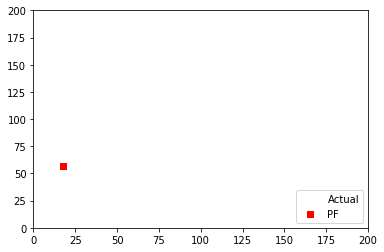

150
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


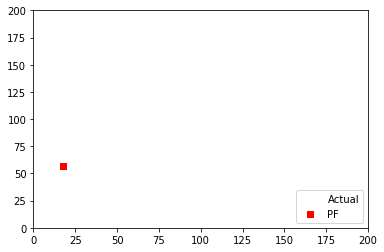

151
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


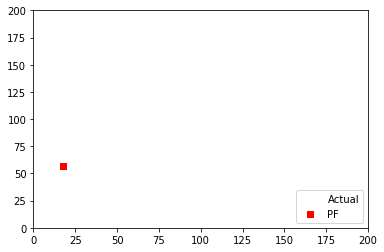

152
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


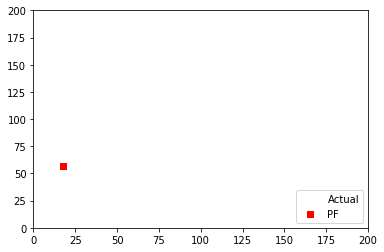

153
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


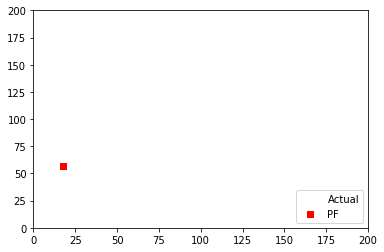

154
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


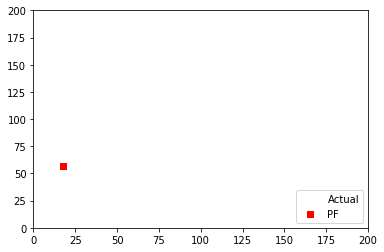

155
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


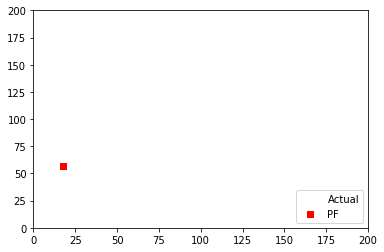

156
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


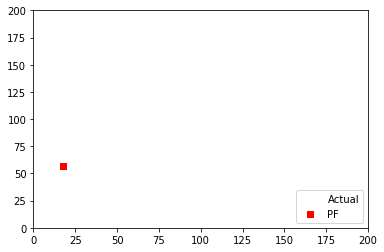

157
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


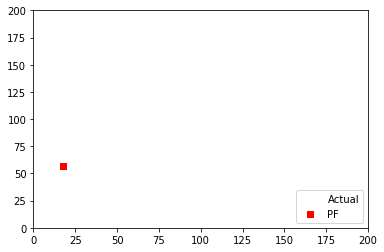

158
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


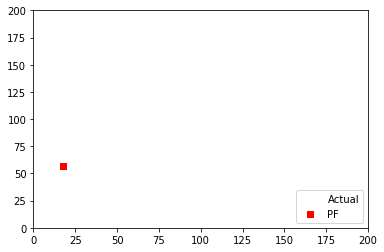

159
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


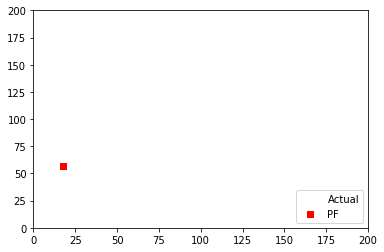

160
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


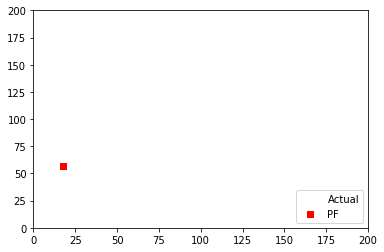

161
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


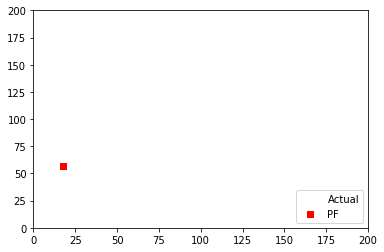

162
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


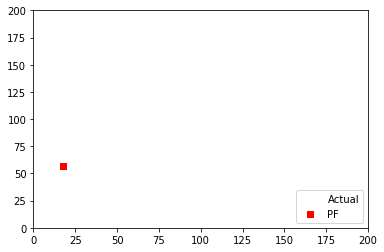

163
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


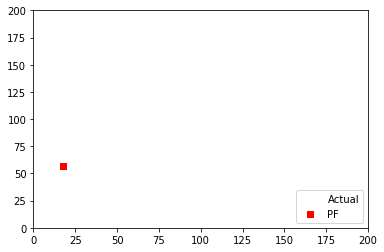

164
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


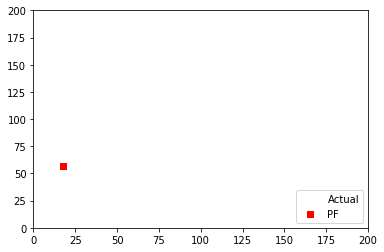

165
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


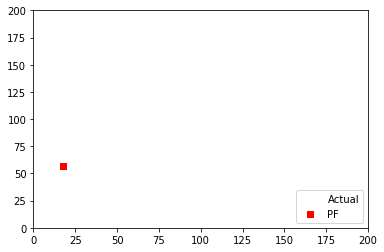

166
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


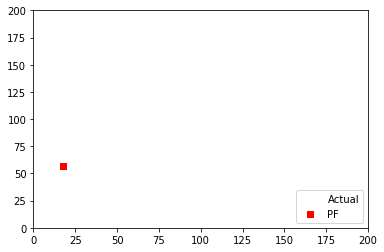

167
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


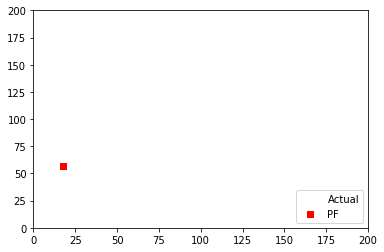

168
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


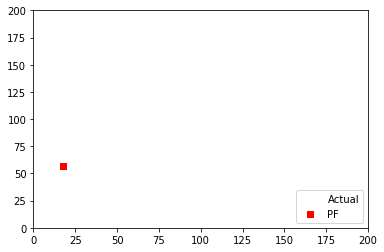

169
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


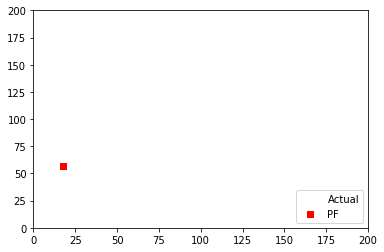

170
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


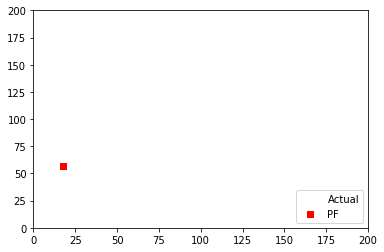

171
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


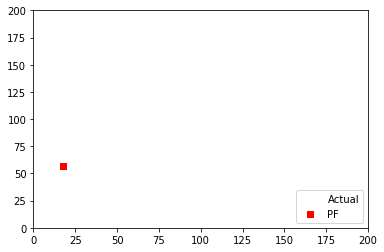

172
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


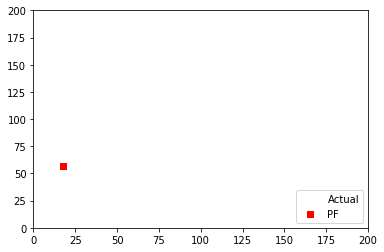

173
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


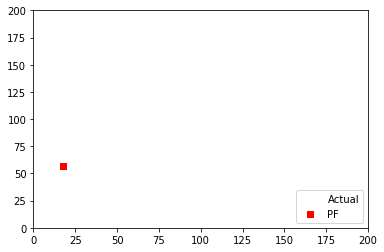

174
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


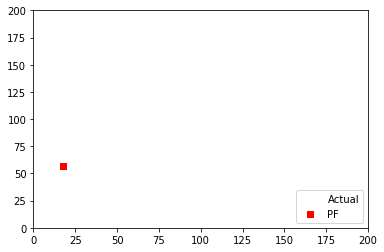

175
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


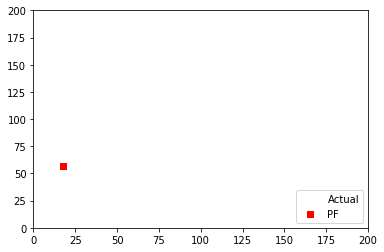

176
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


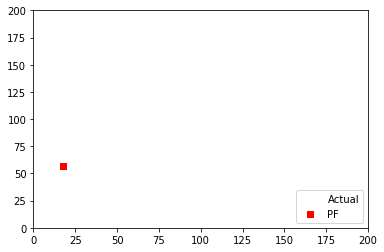

177
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


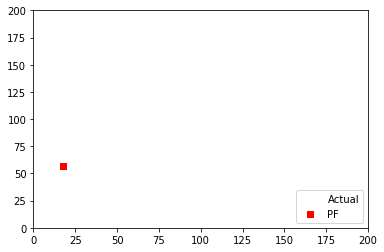

178
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


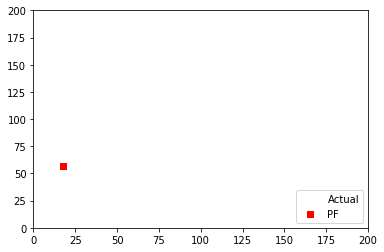

179
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


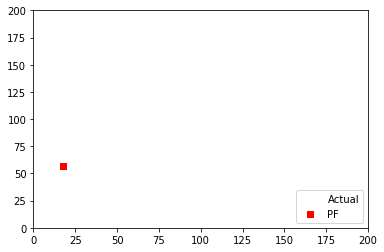

180
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


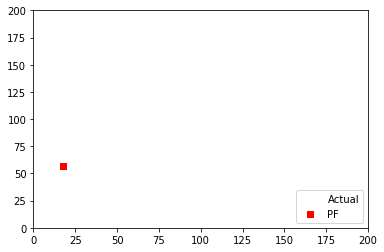

181
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


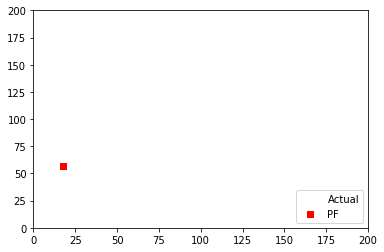

182
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


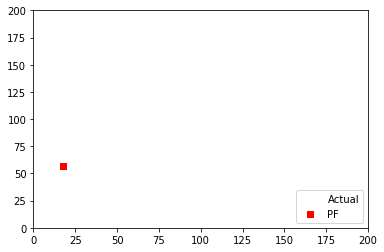

183
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


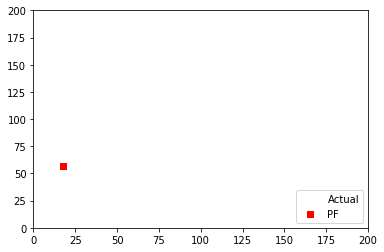

184
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


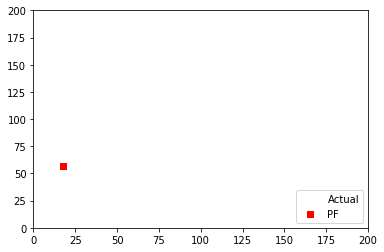

185
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


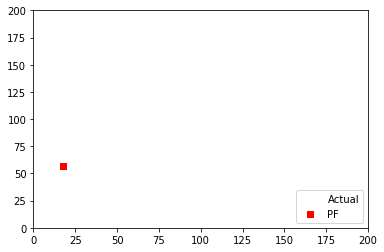

186
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


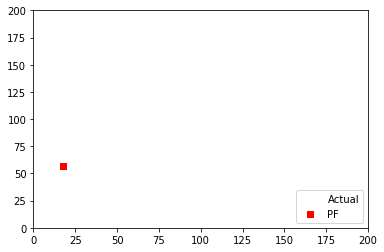

187
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


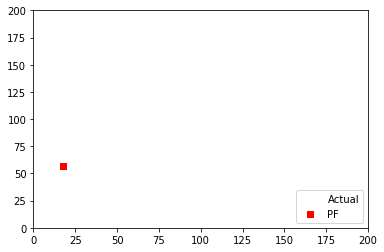

188
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


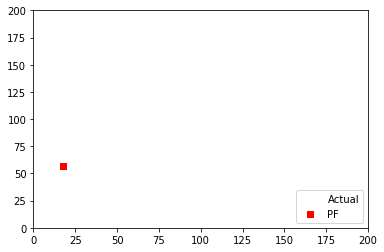

189
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


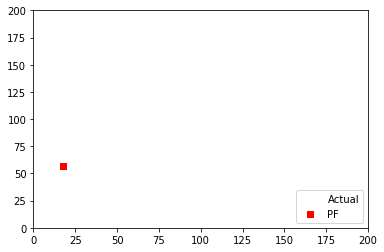

190
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


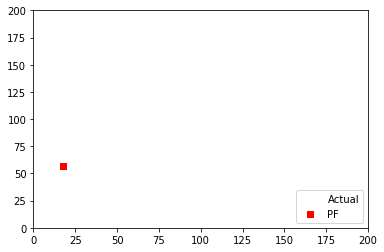

191
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


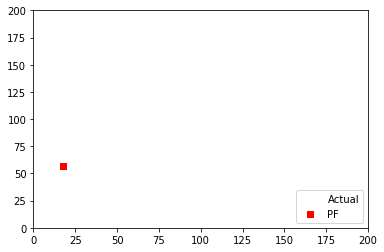

192
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


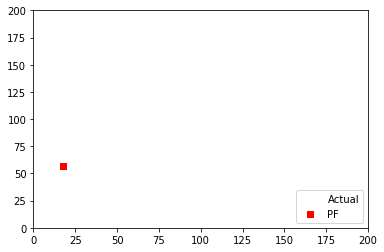

193
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


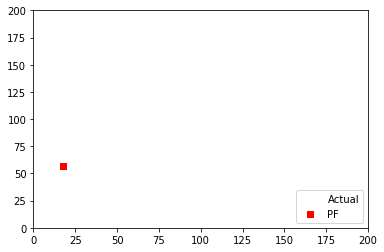

194
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


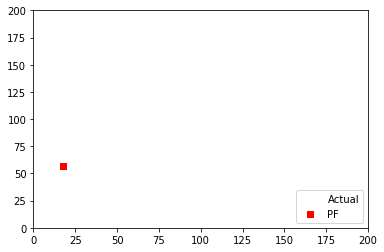

195
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


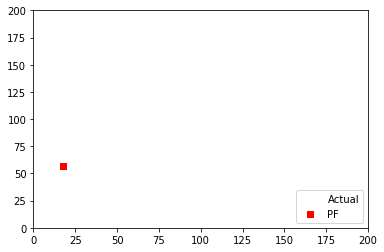

196
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


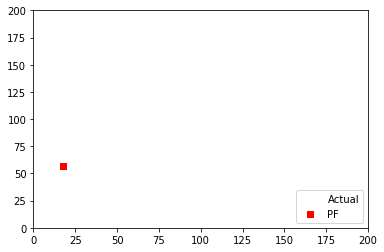

197
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


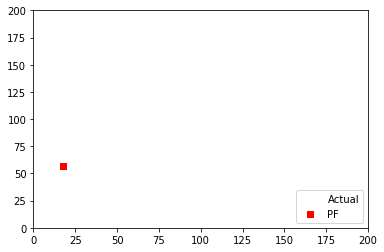

198
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


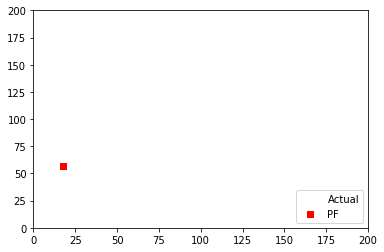

199
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


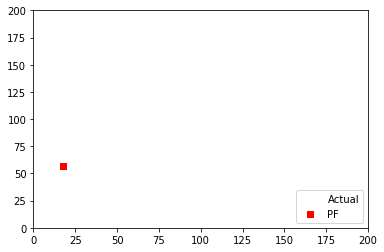

200
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


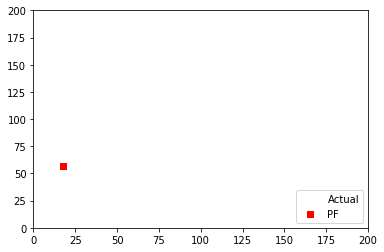

201
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


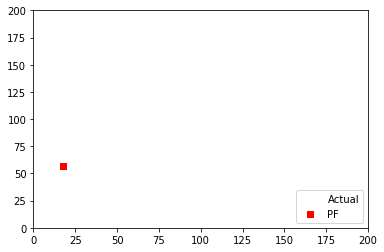

202
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


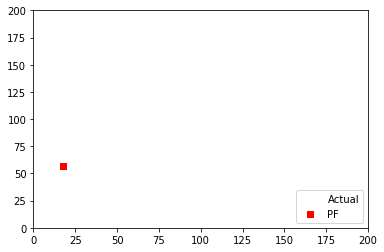

203
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


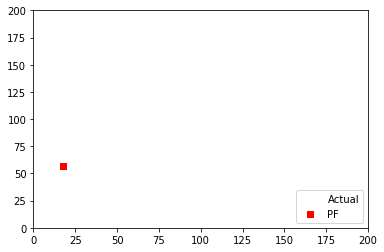

204
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


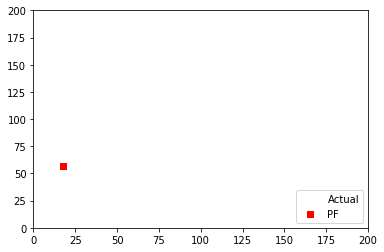

205
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


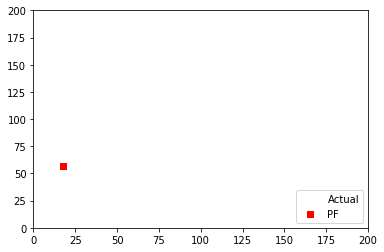

206
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


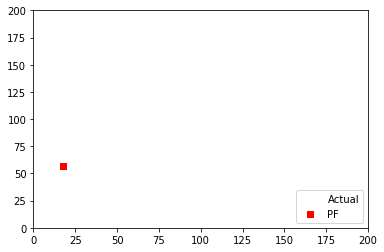

207
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


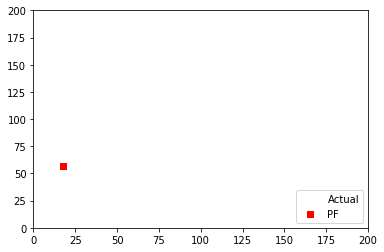

208
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


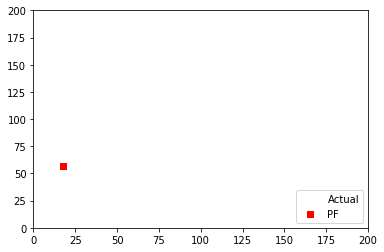

209
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


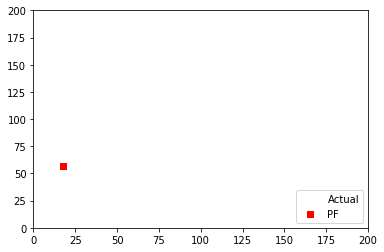

210
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


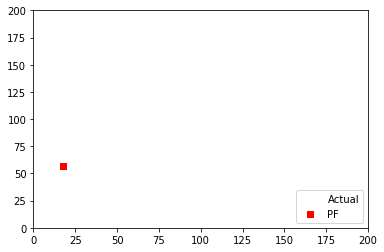

211
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


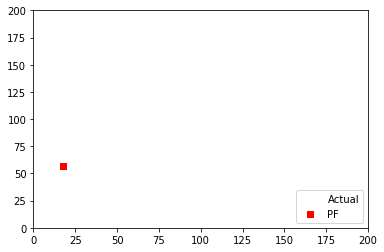

212
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


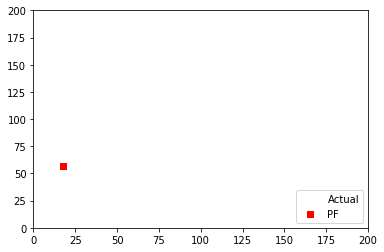

213
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


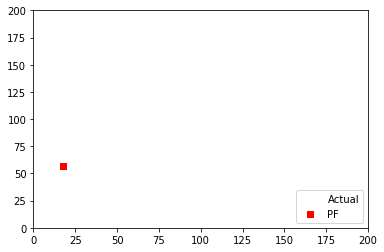

214
infered loc:
[21.         71.05357143]
real loc:
[21.5 75. ]


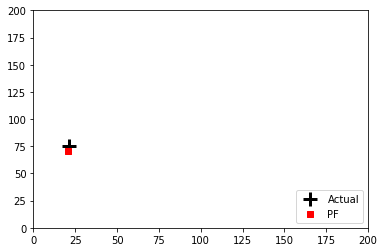

215
infered loc:
[12.         86.05357143]
real loc:
[ 8.6 86. ]


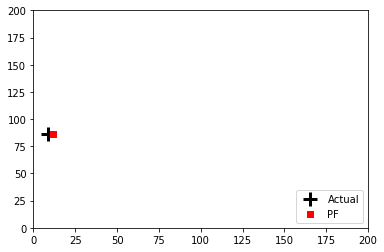

216
infered loc:
[21.         71.05357143]
real loc:
[15.8 70. ]


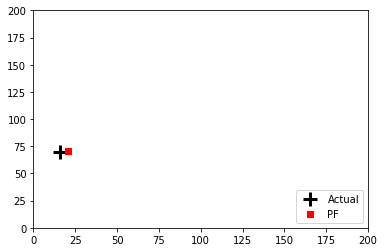

217
infered loc:
[18.         57.05357143]
real loc:
[19.4 62. ]


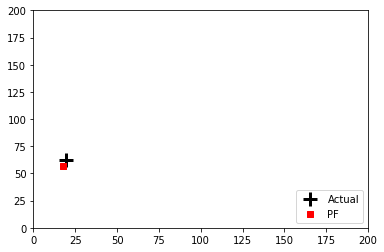

218
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


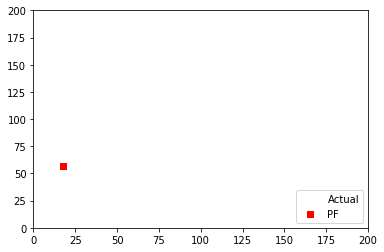

219
infered loc:
[12.         86.05357143]
real loc:
[13.66667 84.83333]


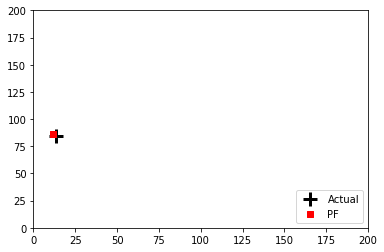

220
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


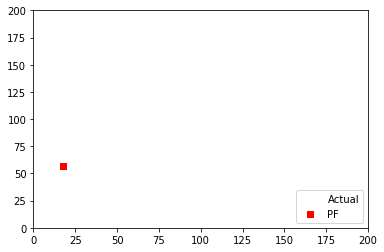

221
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


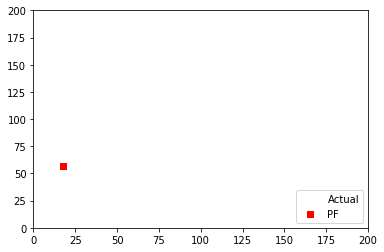

222
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


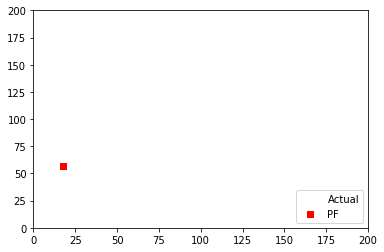

223
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


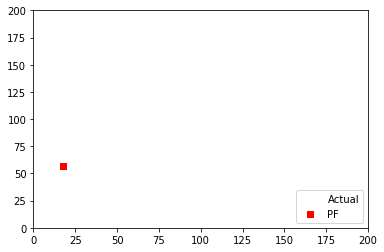

224
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


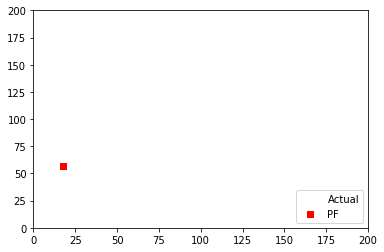

225
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


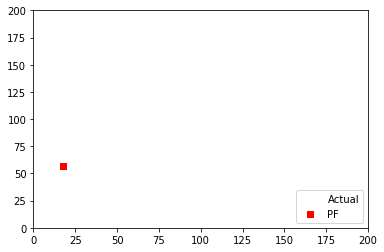

226
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


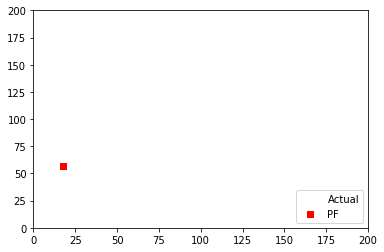

227
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


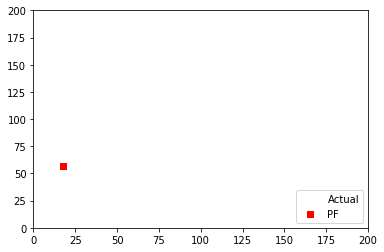

228
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


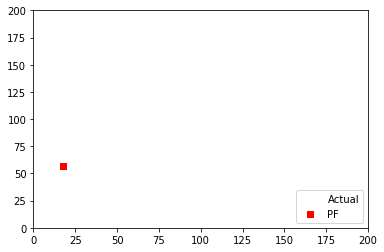

229
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


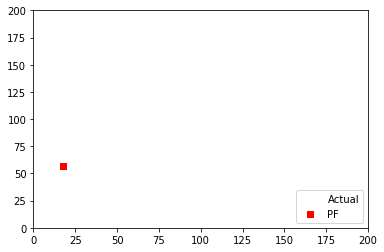

230
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


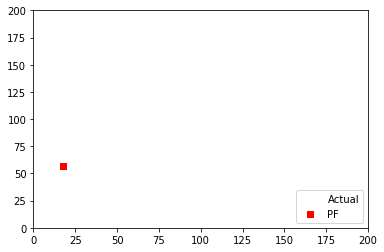

231
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


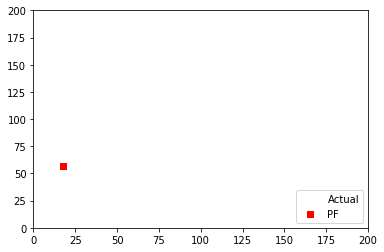

232
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


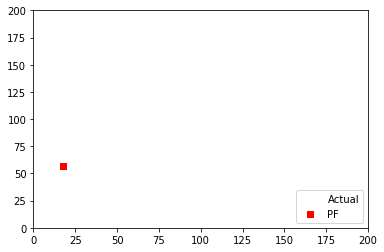

233
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


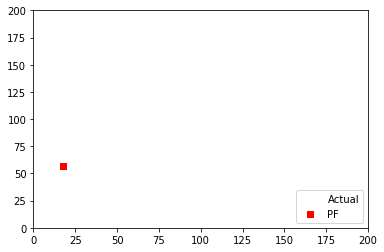

234
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


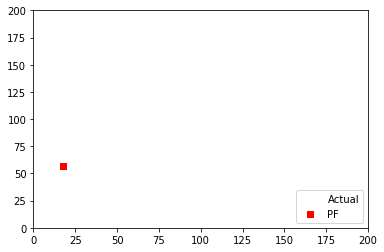

235
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


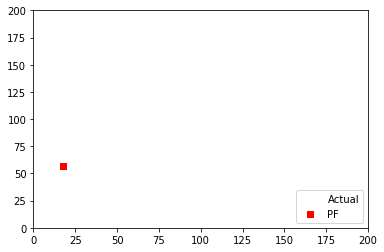

236
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


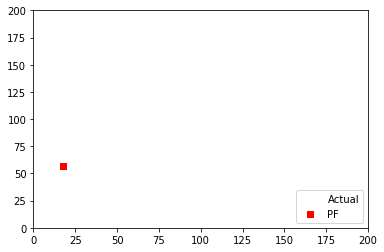

237
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


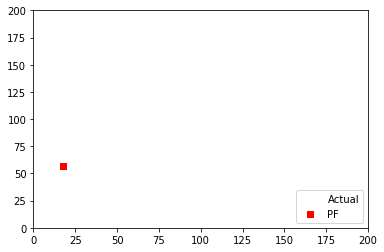

238
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


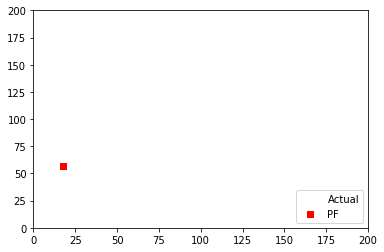

239
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


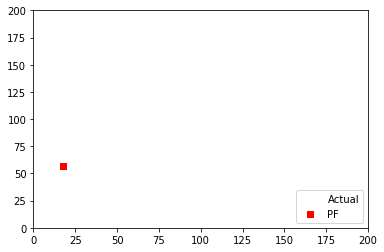

240
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


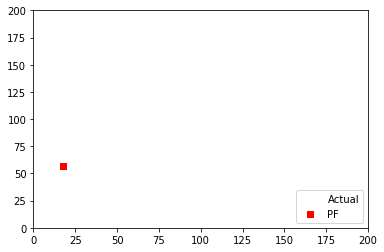

241
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


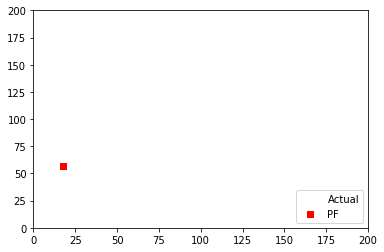

242
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


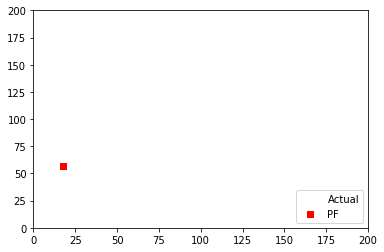

243
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


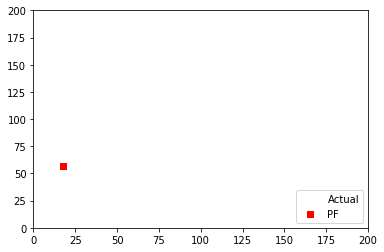

244
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


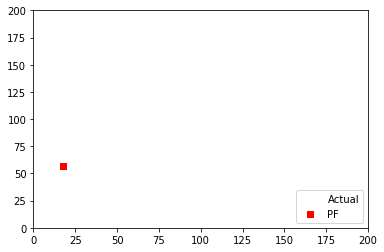

245
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


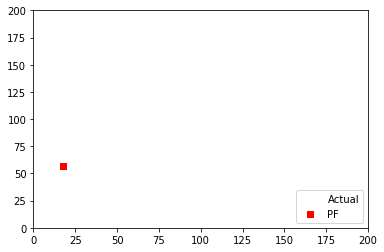

246
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


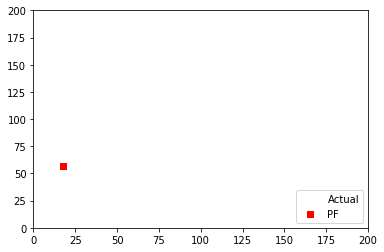

247
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


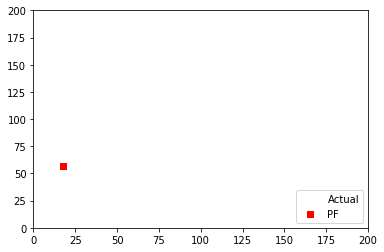

248
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


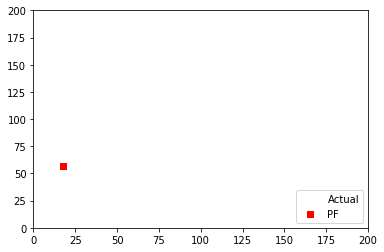

249
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


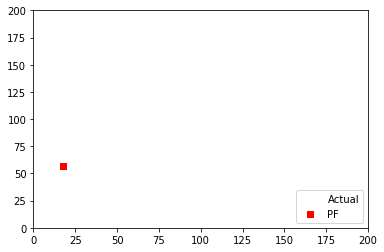

250
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


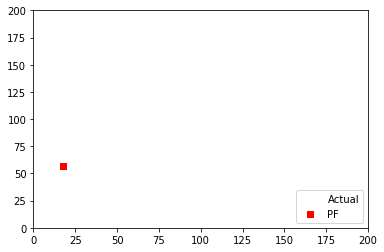

251
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


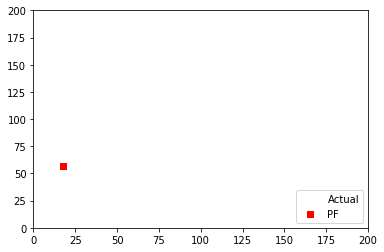

252
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


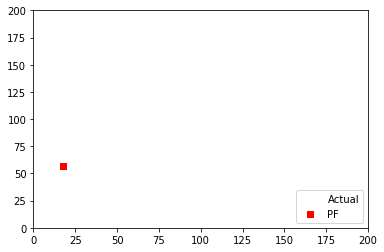

253
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


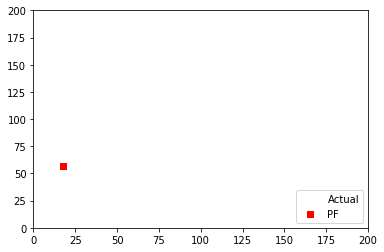

254
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


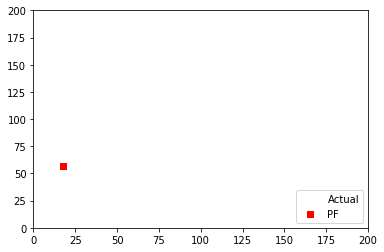

255
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


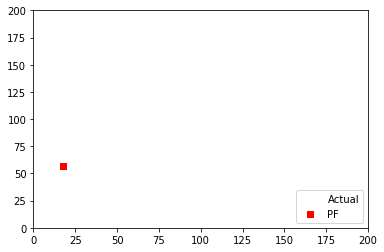

256
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


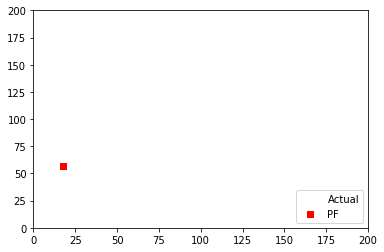

257
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


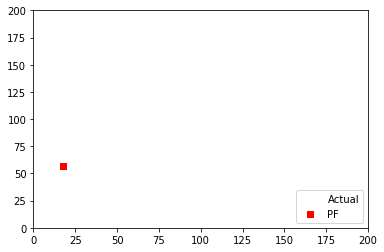

258
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


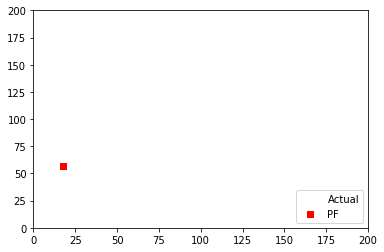

259
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


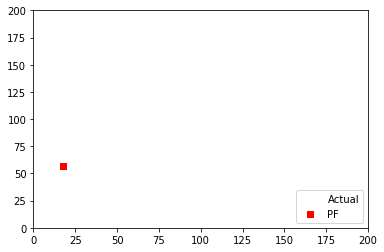

260
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


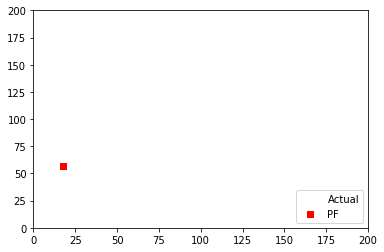

261
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


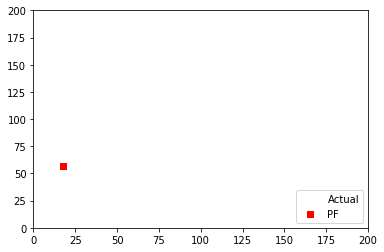

262
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


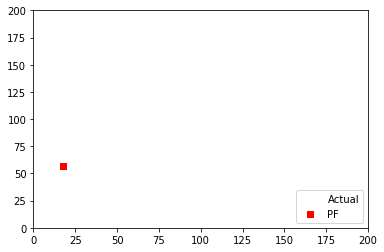

263
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


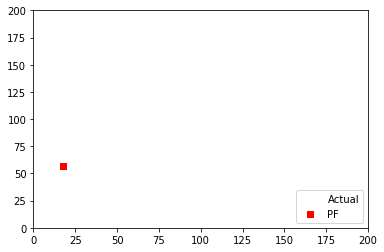

264
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


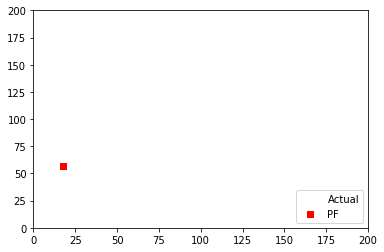

265
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


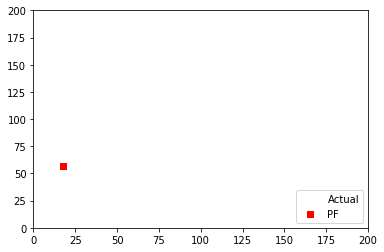

266
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


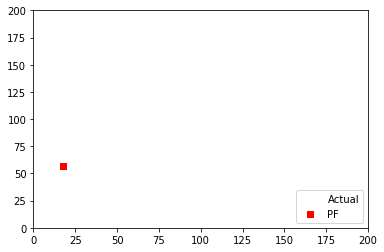

267
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


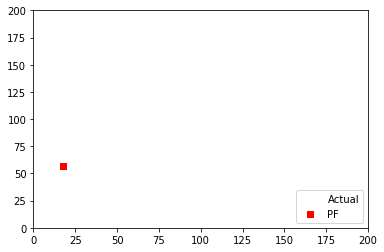

268
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


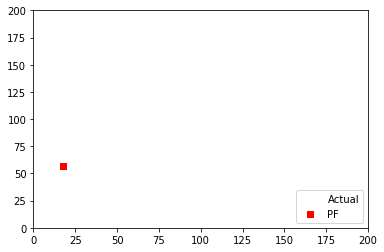

269
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


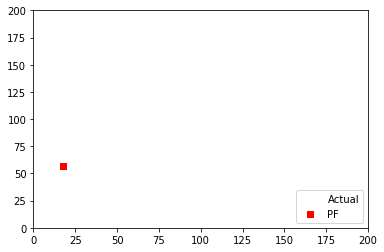

270
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


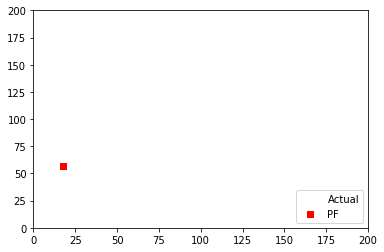

271
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


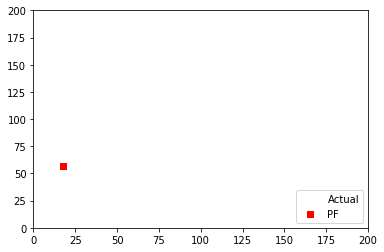

272
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


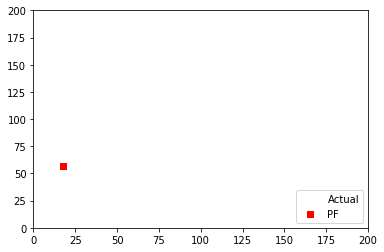

273
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


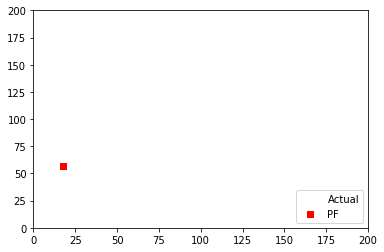

274
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


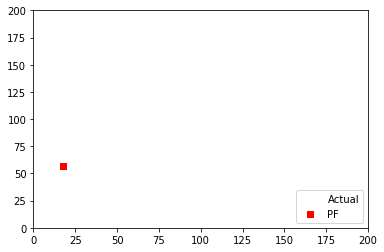

275
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


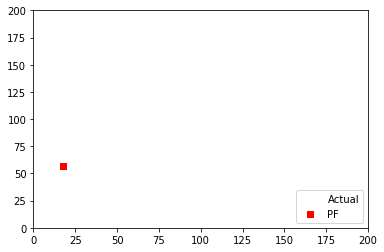

276
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


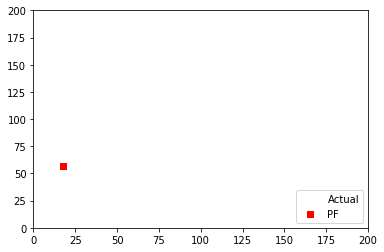

277
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


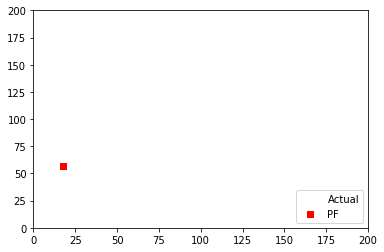

278
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


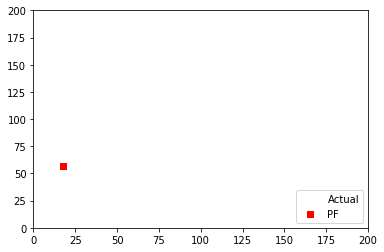

279
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


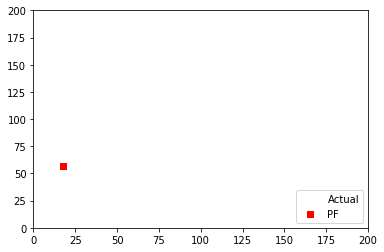

280
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


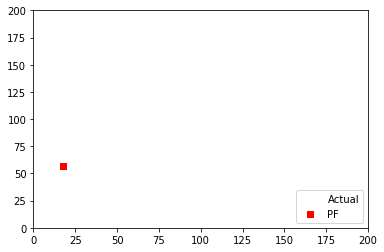

281
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


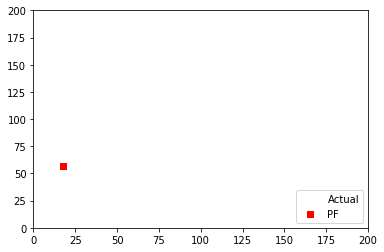

282
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


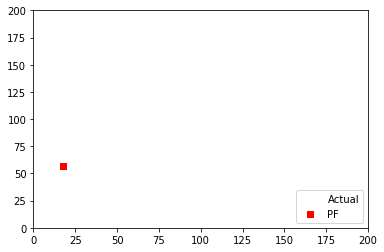

283
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


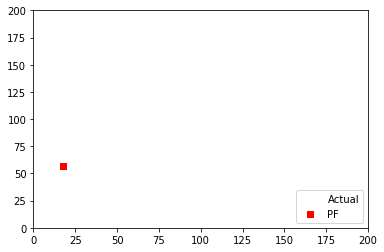

284
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


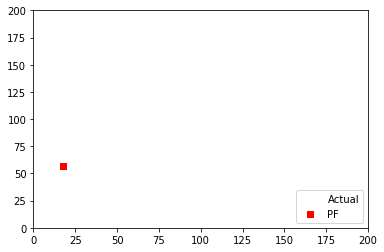

285
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


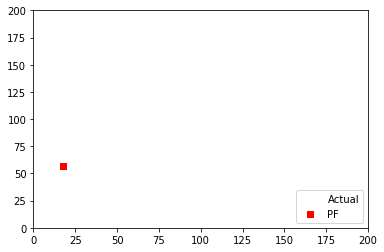

286
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


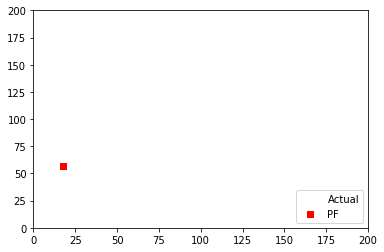

287
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


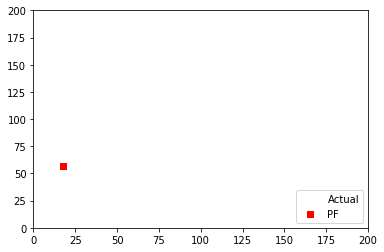

288
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


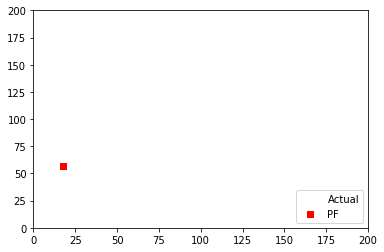

289
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


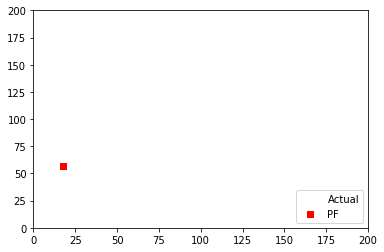

290
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


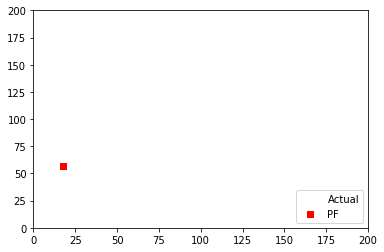

291


In [ ]:
%matplotlib inline
plt.figure()
readFileCSV()

In [ ]:
len(dataset)

In [ ]:
completed_dataset = ['time', 'gt(x)', 'gt(y)', 'gt_motion_readings', 'sim_motion_readings']
for i in range(0, len(simulated_sensor_readings)):
    completed_dataset.append((dataset[i], simulated_sensor_readings[i]))

In [ ]:
completed_dataset[5][0][0]

In [ ]:
import pandas as pd

indices_to_keep = [0, 1, 2, 3, 4, 5, 11, 15, 16, 17, 18, 19, 20, 21]

templist = [0] * 14
for i in range(0, len(dataset[1:, 3])):
    numlist = [int(s) for s in dataset[1:, 3][i] if s.isdigit()]
    numlist = [numlist[j] for j in range(0, len(numlist)) if j in indices_to_keep]
    templist.append(numlist)
    
templist_modified = [0] * 14
for row in range(1, len(templist)):
    history = templist_modified[row - 1]
    row_modified = [0] * 14
    for i in range(len(history)):    
        if (templist[row][i] == 0 and history[i] == 1):
            row_modified[i] = 1
        
        elif (templist[row][i] == 1 and history[i] == 1):
            row_modified[i] = 0
            
        elif (templist[row][i] == 0 and history[i] == 0):
            row_modified[i] = 0
        
        elif (templist[row][i] == 1 and history[i] == 0):
            row_modified[i] = 1
        
    templist_modified.append(row_modified)
        

    
    
    
columns = ['time', 'gt(x)', 'gt(y)', 'gt_motion_readings', 'sim_motion_readings']
index = range(0, len(simulated_sensor_readings))

df = pd.DataFrame(index = index, columns = columns)

datadict = {'time' : dataset[1:, 0], 'gt(x)' : dataset[1:, 1], 'gt(y)' : dataset[1:, 2], 
            'gt_motion_readings' : templist_modified, 'sim_motion_readings' : simulated_sensor_readings}

df = pd.DataFrame(datadict)

In [ ]:
gt_readings = {}

for sensor in range(0, 14):
    gt_readings[sensor] = []
    for i in range(0, len(df['gt_motion_readings'])):
        gt_readings[sensor].append(df['gt_motion_readings'][i][sensor])
        
        
sim_readings = {}

for sensor in range(0, 14):
    sim_readings[sensor] = []
    for i in range(0, len(df['sim_motion_readings'])):
        sim_readings[sensor].append(df['sim_motion_readings'][i][sensor])

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(gt_readings)):
    plt.plot(list(range(0,len(gt_readings[i]))), gt_readings[i])
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(sim_readings)):
    plt.plot(list(range(0,len(sim_readings[i]))), sim_readings[i])
    plt.show()

In [ ]:
print("please start simulation in casi now.")

In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)

In [ ]:
from random import shuffle
x = [i for i in range(8)]
shuffle(x)
print(x)

In [ ]:
x